In [193]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from fontTools.misc.bezierTools import calcCubicArcLength
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, OneHotEncoder, StandardScaler

data = pd.read_csv(r"C:\Users\demir\OneDrive\Desktop\MSc Thesis\Data\feature_eng\distributed_fuels.csv", delimiter=';')
data = data.loc[data['devol_yield'] > 0]
data = data.reset_index(drop=True)

o_h = data['o']/data['h']
T_time = data['residence_time']*data['temperature']
T_rate = data['temperature']/data['heat_rate']
vm_fc = data['vm']/data['fc']
ac_fc = data['ac']/data['fc']

data = data.drop(['h', 'o', 'c', 'wc', 'lhv', 'vm', 'ac', 'fc'], axis=1)
data = pd.concat([data, vm_fc.rename('VM/FC'), ac_fc.rename('AC/FC')], axis=1)

X_eng = data.drop(['devol_yield', 'sample'], axis=1)
y_eng = data['devol_yield']

X_eng = X_eng.reset_index(drop=True)
y_eng = y_eng.reset_index(drop=True)


X_eng_train, X_eng_test, y_eng_train, y_eng_test = train_test_split(X_eng, y_eng, test_size=0.2, random_state=42)

scaler = StandardScaler()
scaler.fit(X_eng_train)

X_eng_train = pd.DataFrame(scaler.transform(X_eng_train), columns=X_eng_train.columns)
X_eng_test = pd.DataFrame(scaler.transform(X_eng_test), columns=X_eng_test.columns)

print(f"Train set: X_train={X_eng_train.shape}, y_train={y_eng_train.shape}")
print(f"Test set: X_test={X_eng_test.shape}, y_test={y_eng_test.shape}")


Train set: X_train=(1589, 11), y_train=(1589,)
Test set: X_test=(398, 11), y_test=(398,)


In [187]:
print(data.columns)

Index(['sample', 'temperature', 'residence_time', 'pressure', 'heat_rate', 'n',
       's', 'cl', 'hc', 'oc', 'devol_yield', 'H/O', 'time_till_Tset', 'VM/FC',
       'AC/FC'],
      dtype='object')


In [117]:
low_oxygen = data.loc[data['oc'] < 5]
med_oxygen = data.loc[(data['oc'] >= 5) & (data['oc'] < 20)]
high_oxygen = data.loc[data['oc'] >= 20]

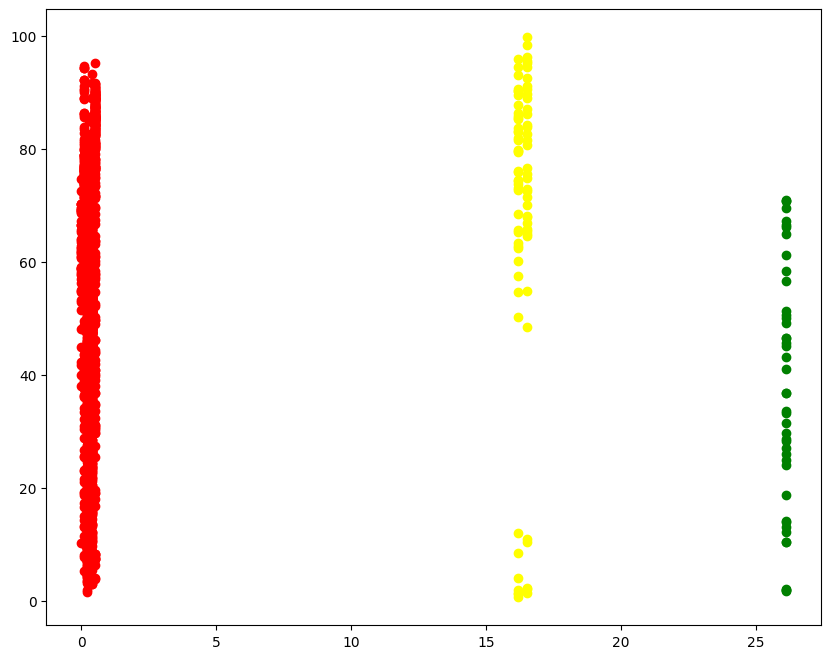

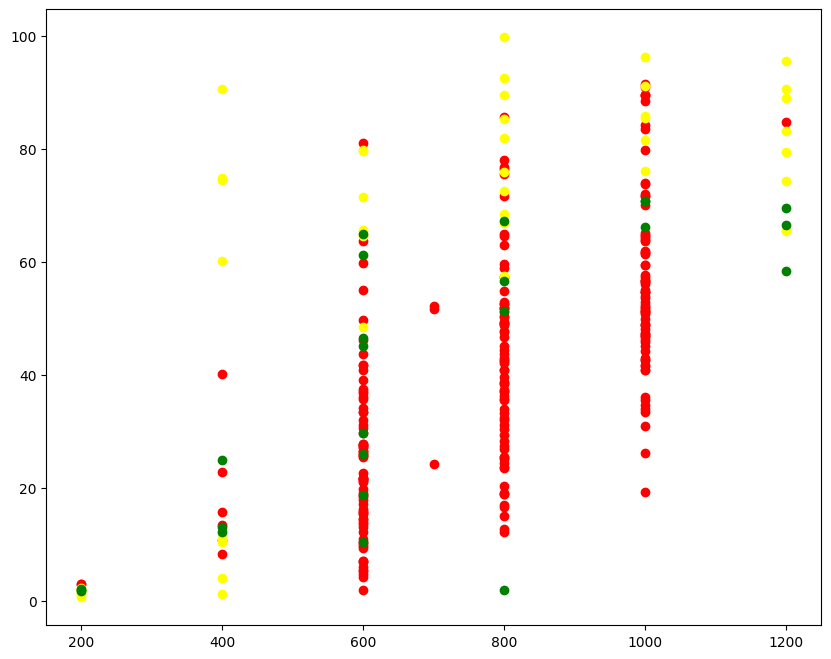

In [134]:
plt.figure(figsize=[10,8])
plt.scatter(low_oxygen['oc'], low_oxygen['devol_yield'], color='red')
plt.scatter(med_oxygen['oc'], med_oxygen['devol_yield'], color='yellow')
plt.scatter(high_oxygen['oc'], high_oxygen['devol_yield'], color='green')
plt.show()

plt.figure(figsize=[10,8])
plt.scatter(low_oxygen['temperature'].loc[(low_oxygen['residence_time'] == 1) & (low_oxygen['pressure'] == 1)], low_oxygen['devol_yield'].loc[(low_oxygen['residence_time'] == 1) & (low_oxygen['pressure'] == 1)], color='red')

plt.scatter(med_oxygen['temperature'].loc[(med_oxygen['residence_time'] == 1) & (med_oxygen['pressure'] == 1)], med_oxygen['devol_yield'].loc[(med_oxygen['residence_time'] == 1) & (med_oxygen['pressure'] == 1)], color='yellow')

plt.scatter(high_oxygen['temperature'].loc[(high_oxygen['residence_time'] == 1) & (high_oxygen['pressure'] == 1)], high_oxygen['devol_yield'].loc[(high_oxygen['residence_time'] == 1) & (high_oxygen['pressure'] == 1)], color='green')
plt.show()


In [207]:
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

In [208]:
def remove_outliers_zscore(df, column, threshold=3):
    mean = df[column].mean()
    std = df[column].std()
    z_scores = np.abs((df[column] - mean) / std)
    return df[z_scores <= threshold]

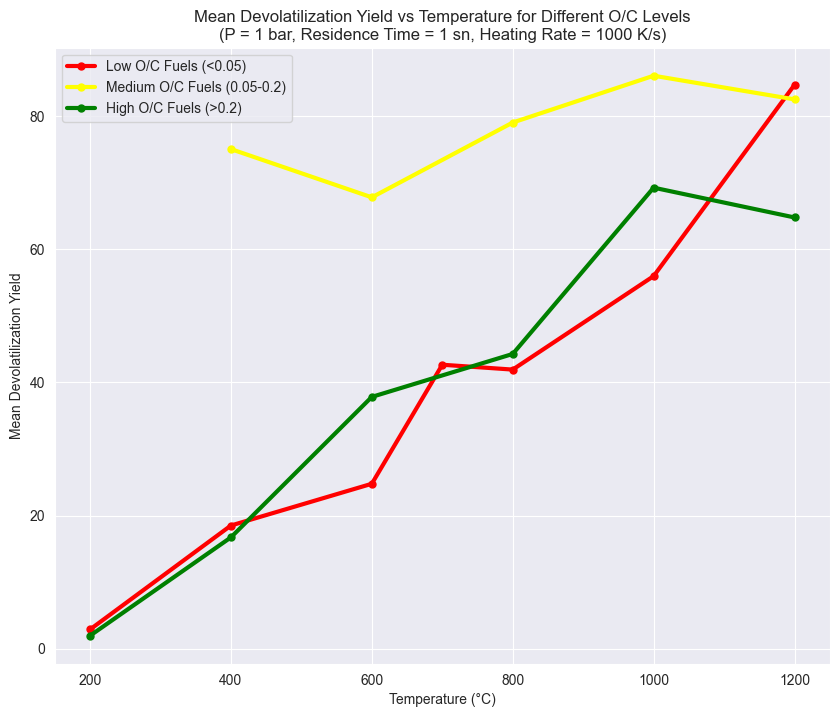

In [147]:
data = pd.read_csv(r"C:\Users\demir\OneDrive\Desktop\MSc Thesis\Data\feature_eng\distributed_fuels.csv", delimiter=';')
data = data.loc[data['devol_yield'] > 0]

low_oxygen = remove_outliers(data.loc[data['oc'] < 5], 'devol_yield')
med_oxygen = remove_outliers(data.loc[(data['oc'] >= 5) & (data['oc'] < 20)], 'devol_yield')
high_oxygen = remove_outliers(data.loc[data['oc'] >= 20], 'devol_yield')

low_mean = low_oxygen.loc[(low_oxygen['residence_time'] == 1) & (low_oxygen['pressure'] == 1) & (low_oxygen['heat_rate'] == 1000)].groupby('temperature')['devol_yield'].mean()
med_mean = med_oxygen.loc[(med_oxygen['residence_time'] == 1) & (med_oxygen['pressure'] == 1) & (med_oxygen['heat_rate'] == 1000)].groupby('temperature')['devol_yield'].mean()
high_mean = high_oxygen.loc[(high_oxygen['residence_time'] == 1) & (high_oxygen['pressure'] == 1) & (high_oxygen['heat_rate'] == 1000)].groupby('temperature')['devol_yield'].mean()

# Plot the mean devol_yield as a line plot
plt.figure(figsize=[10,8])
plt.plot(low_mean.index, low_mean.values, color='red', label='Low O/C Fuels (<0.05)', marker='o', markersize=5, linewidth=3)
plt.plot(med_mean.index, med_mean.values, color='yellow', label='Medium O/C Fuels (0.05-0.2)', marker = 'o' , markersize=5, linewidth=3)
plt.plot(high_mean.index, high_mean.values, color='green', label='High O/C Fuels (>0.2)',  marker='o', markersize=5, linewidth=3)

# Formatting the plot
plt.xlabel("Temperature (°C)")
plt.ylabel("Mean Devolatilization Yield")
plt.title("Mean Devolatilization Yield vs Temperature for Different O/C Levels\n(P = 1 bar, Residence Time = 1 sn, Heating Rate = 1000 K/s)")
plt.legend()

# Show the plot
plt.show()

In [153]:
from sklearn.feature_selection import mutual_info_regression
imputer = KNNImputer(n_neighbors=2)
data = data.drop(columns=['sample'])
data_imputed = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)
X = data_imputed.drop(['devol_yield'], axis=1)
y = data_imputed['devol_yield']
mi_scores = mutual_info_regression(X, y)

# Convert to a DataFrame for better visualization
mi_df = pd.DataFrame({'Feature': X.columns, 'MI Score': mi_scores})
mi_df = mi_df.sort_values(by='MI Score', ascending=False)



# Display results
print(mi_df)

           Feature  MI Score
16             lhv  0.464499
12               s  0.460547
7               ac  0.448281
10               o  0.436948
9                h  0.432916
5               vm  0.426486
8                c  0.422894
11               n  0.421543
4               wc  0.384476
14              hc  0.378641
6               fc  0.372005
15              oc  0.371288
0      temperature  0.242682
13              cl  0.193206
1   residence_time  0.109187
3        heat_rate  0.056896
2         pressure  0.042703


In [131]:
low_h = data.loc[data['hc'] < 0.8]
med_h = data.loc[(data['hc'] >= 0.9) & (data['oc'] < 1.3)]
high_h = data.loc[data['hc'] >= 1.3]

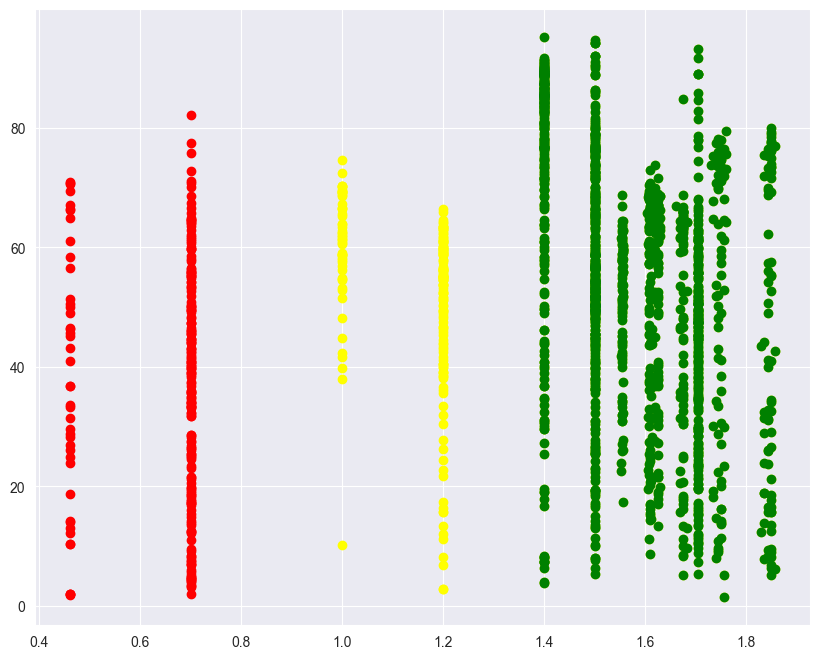

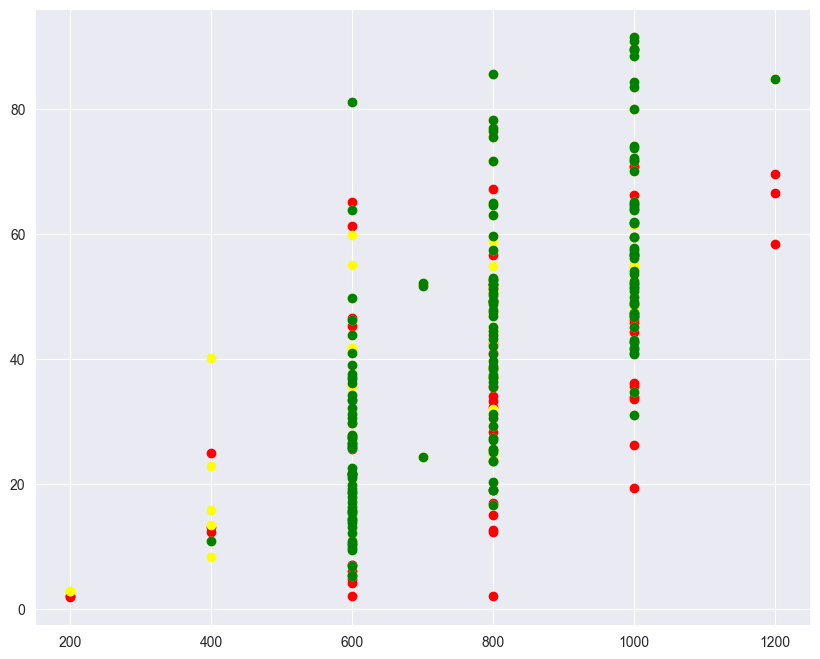

In [132]:
plt.figure(figsize=[10,8])
plt.scatter(low_h['hc'], low_h['devol_yield'], color='red')
plt.scatter(med_h['hc'], med_h['devol_yield'], color='yellow')
plt.scatter(high_h['hc'], high_h['devol_yield'], color='green')
plt.show()

plt.figure(figsize=[10,8])
plt.scatter(low_h['temperature'].loc[(low_h['residence_time'] == 1) & (low_h['pressure'] == 1)], low_h['devol_yield'].loc[(low_h['residence_time'] == 1) & (low_h['pressure'] == 1)], color='red')

plt.scatter(med_h['temperature'].loc[(med_h['residence_time'] == 1) & (med_h['pressure'] == 1)], med_h['devol_yield'].loc[(med_h['residence_time'] == 1) & (med_h['pressure'] == 1)], color='yellow')

plt.scatter(high_h['temperature'].loc[(high_h['residence_time'] == 1) & (high_h['pressure'] == 1)], high_h['devol_yield'].loc[(high_h['residence_time'] == 1) & (high_h['pressure'] == 1)], color='green')
plt.show()

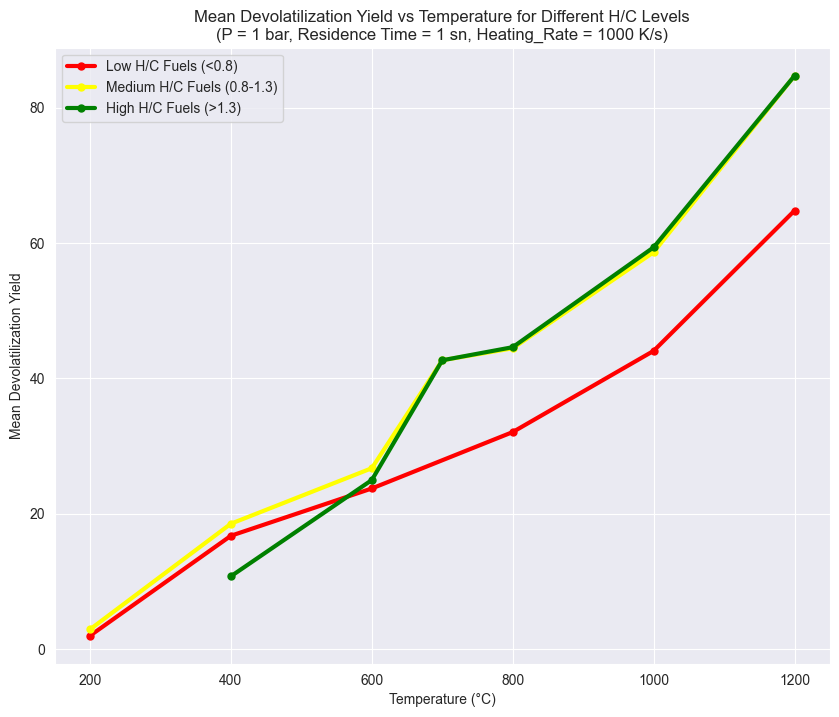

In [134]:
low_h = remove_outliers(data.loc[data['hc'] < 0.8], 'devol_yield')
med_h = remove_outliers(data.loc[(data['hc'] >= 0.9) & (data['oc'] < 1.3)], 'devol_yield')
high_h = remove_outliers(data.loc[data['hc'] >= 1.3], 'devol_yield')

low_h_mean = low_h.loc[(low_h['residence_time'] == 1) & (low_h['pressure'] == 1) & (low_h['heat_rate'] == 1000)].groupby('temperature')['devol_yield'].mean()
med_h_mean = med_h.loc[(med_h['residence_time'] == 1) & (med_h['pressure'] == 1)& (med_h['heat_rate'] == 1000)].groupby('temperature')['devol_yield'].mean()
high_h_mean = high_h.loc[(high_h['residence_time'] == 1) & (high_h['pressure'] == 1)& (high_h['heat_rate'] == 1000)].groupby('temperature')['devol_yield'].mean()

# Plot the mean devol_yield as a line plot
plt.figure(figsize=[10,8])
plt.plot(low_h_mean.index, low_h_mean.values, color='red', label='Low H/C Fuels (<0.8)', marker='o', markersize=5, linewidth=3)
plt.plot(med_h_mean.index, med_h_mean.values, color='yellow', label='Medium H/C Fuels (0.8-1.3)', marker = 'o' , markersize=5, linewidth=3)
plt.plot(high_h_mean.index, high_h_mean.values, color='green', label='High H/C Fuels (>1.3)',  marker='o', markersize=5, linewidth=3)

# Formatting the plot
plt.xlabel("Temperature (°C)")
plt.ylabel("Mean Devolatilization Yield")
plt.title("Mean Devolatilization Yield vs Temperature for Different H/C Levels\n(P = 1 bar, Residence Time = 1 sn, Heating_Rate = 1000 K/s)")
plt.legend()

# Show the plot
plt.show()

### Adding Categorical Data for Fuel Types

Fuel types as new column has been added and binary transformation has been done by one hot encoding

In [210]:
from sklearn.preprocessing import RobustScaler, OneHotEncoder

data = pd.read_csv(r"C:\Users\demir\OneDrive\Desktop\MSc Thesis\Data\feature_eng\distributed_fuels.csv", delimiter=';')
data = data.loc[data['devol_yield'] > 0]

data.loc[data['sample'].str.contains('gm|gumm', na=False), 'o'] = 0.1

def classify_fuel(sample):
    sample = str(sample).lower()
    if "gumm" in sample or "gm" in sample:
        return "gummipulver"
    elif "wod" in sample or 'wood' in sample or 'wd' in sample:
        return "wood"
    elif "coal" in sample or 'bks' in sample:
        return "coal"
    elif "swage" in sample or 'swg' in sample or 'sewage' in sample:
        return "sewage"
    elif "refuse" in sample or 'ref' in sample:
        return "ebs2"
    elif "digestate" in sample or 'dgst' in sample or "dgt" in sample:
        if 'pe' or 'pp' or 'car' not in sample:
            return "digestate"
        else:
            return "digestate_mix"
    elif "htc" in sample:
        return "HTC-MSW"
    elif "cel" in sample:
        return "cellulose"
    elif "hc" in sample:
        return "Hemicellulose"
    elif "lig" in sample:
        return "Lignin"
    elif "ebs2" in sample:
        return "ebs2"
    elif "ebs1" in sample:
        return "ebs1"
    else:
        return "unknown"  # Default category

data['fuel_type'] = data['sample'].apply(classify_fuel)

T_time = data['residence_time']*data['temperature']
T_rate = data['temperature']/data['heat_rate']
vm_fc = data['vm']/data['fc']
ac_fc = data['ac']/data['fc']

data = data.drop(['oc', 'hc','sample'], axis=1)
print(data.head())

   temperature  residence_time  pressure  heat_rate    wc    vm    fc   ac  \
0          600             0.5       1.0       1000  10.8  44.2  40.9  4.2   
1          600             0.5       1.0       1000  10.8  44.2  40.9  4.2   
2          600             0.5       1.0       1000  10.8  44.2  40.9  4.2   
3          600             0.5       1.0       1000  10.8  44.2  40.9  4.2   
4          600             1.0       1.0       1000  10.8  44.2  40.9  4.2   

      c    h     o    n    s   cl    lhv  devol_yield fuel_type  
0  63.4  3.9  16.2  0.9  0.6  0.0  20.13     3.437227      coal  
1  63.4  3.9  16.2  0.9  0.6  0.0  20.13     3.163017      coal  
2  63.4  3.9  16.2  0.9  0.6  0.0  20.13     4.827940      coal  
3  63.4  3.9  16.2  0.9  0.6  0.0  20.13     4.509894      coal  
4  63.4  3.9  16.2  0.9  0.6  0.0  20.13     4.128819      coal  


In [250]:
from sklearn.impute import KNNImputer

categorical_columns = data.select_dtypes(include=['object']).columns.tolist()
encoder = OneHotEncoder(sparse_output=False)
one_hot_encoded = encoder.fit_transform(data[categorical_columns])
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_columns))
df_encoded = pd.concat([data, one_hot_df], axis=1)
data_encoded = df_encoded.drop(categorical_columns, axis=1)

imputer = KNNImputer(n_neighbors=2)
data_encoded_imputed = pd.DataFrame(imputer.fit_transform(data_encoded), columns=data_encoded.columns)

X_eng = data_encoded_imputed.drop(['devol_yield'], axis=1)
y_eng = data_encoded_imputed['devol_yield']

print(X_eng.columns)

Index(['temperature', 'residence_time', 'pressure', 'heat_rate', 'wc', 'vm',
       'fc', 'ac', 'c', 'h', 'o', 'n', 's', 'cl', 'lhv', 'fuel_type_HTC-MSW',
       'fuel_type_Hemicellulose', 'fuel_type_Lignin', 'fuel_type_cellulose',
       'fuel_type_coal', 'fuel_type_digestate', 'fuel_type_ebs1',
       'fuel_type_ebs2', 'fuel_type_gummipulver', 'fuel_type_sewage',
       'fuel_type_wood'],
      dtype='object')


In [231]:
X_eng_train, X_eng_test, y_eng_train, y_eng_test = train_test_split(X_eng, y_eng, test_size=0.2)

scaler = StandardScaler()
scaler.fit(X_eng_train)

X_eng_train = pd.DataFrame(scaler.transform(X_eng_train), columns=X_eng.columns)
X_eng_test = pd.DataFrame(scaler.transform(X_eng_test), columns=X_eng.columns)

print("NaN in y_eng_train:", y_eng_train.isna().sum())
print("NaN in y_eng_test:", y_eng_test.isna().sum())

print("Infinite in y_eng_train:", np.isinf(y_eng_train).sum())
print("Infinite in y_eng_test:", np.isinf(y_eng_test).sum())


print(f"Train set: X_train={X_eng_train.shape}, y_train={y_eng_train.shape}")
print(f"Test set: X_test={X_eng_test.shape}, y_test={y_eng_test.shape}")

NaN in y_eng_train: 0
NaN in y_eng_test: 0
Infinite in y_eng_train: 0
Infinite in y_eng_test: 0
Train set: X_train=(1592, 26), y_train=(1592,)
Test set: X_test=(398, 26), y_test=(398,)


### Variance Inflation Factor


In [245]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import mutual_info_regression

def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

# Compute VIF for X_eng_train
vif_results = calculate_vif(X_eng_train)
print(vif_results)


                    Feature           VIF
0               temperature  1.176566e+00
1            residence_time  1.218804e+00
2                  pressure  1.125766e+00
3                 heat_rate  1.293326e+00
4                        wc  1.307253e+06
5                        vm  3.158544e+07
6                        fc  1.915761e+07
7                        ac  2.845386e+07
8                         c  6.726879e+03
9                         h  3.194305e+02
10                        o  3.627020e+03
11                        n  9.357891e+02
12                        s  2.819876e+02
13                       cl  4.002634e+01
14                      lhv  4.694199e+01
15        fuel_type_HTC-MSW           inf
16  fuel_type_Hemicellulose           inf
17         fuel_type_Lignin           inf
18      fuel_type_cellulose           inf
19           fuel_type_coal           inf
20      fuel_type_digestate           inf
21           fuel_type_ebs1           inf
22           fuel_type_ebs2       

C:\Users\demir\PycharmProjects\volatile-predict\.venv\lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


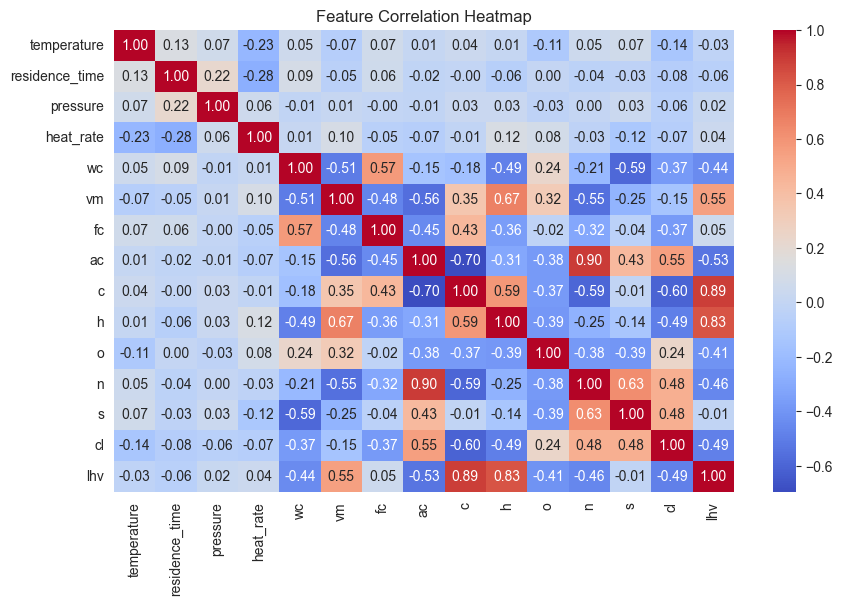

In [234]:
# Compute correlation matrix
corr_matrix = X_eng_train.drop(['fuel_type_HTC-MSW',
       'fuel_type_Hemicellulose', 'fuel_type_Lignin', 'fuel_type_cellulose',
       'fuel_type_coal', 'fuel_type_digestate', 'fuel_type_ebs1',
       'fuel_type_ebs2', 'fuel_type_gummipulver', 'fuel_type_sewage',
       'fuel_type_wood'], axis=1).corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

In [236]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.90)
X_train_pca = pd.DataFrame(pca.fit_transform(X_eng_train))
X_test_pca = pd.DataFrame(pca.transform(X_eng_test))

print(f"Original Feature Count: {X_eng_train.shape[1]}")
print(f"Reduced Feature Count: {X_train_pca.shape[1]}")


Original Feature Count: 26
Reduced Feature Count: 12


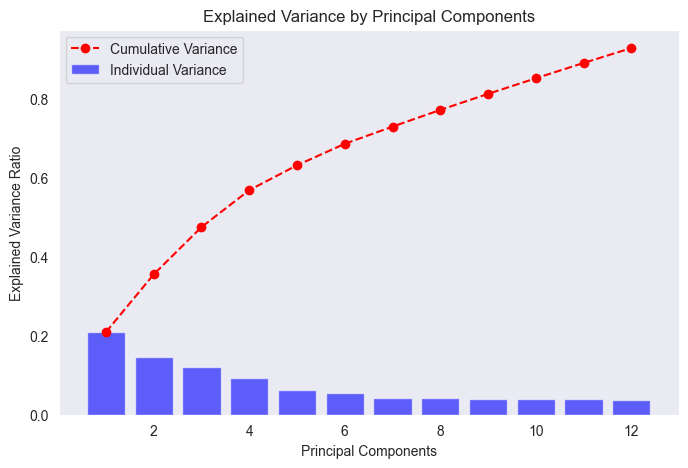

In [237]:
explained_variance = np.cumsum(pca.explained_variance_ratio_)
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Plot individual and cumulative explained variance
plt.figure(figsize=(8, 5))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.6, label='Individual Variance', color='blue')
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--', color='red', label='Cumulative Variance')

# Labels and title
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Principal Components')
plt.legend()
plt.grid()
plt.show()

In [243]:
X_eng_train.shape
y_eng_test.shape

(398,)

## XGB Trained with PCs
Test R-Squared: 0.7508753563681645

Features Before PCA: 'temperature', 'residence_time', 'pressure', 'heat_rate', 'wc', 'vm',
       'fc', 'ac', 'c', 'h', 'o', 'n', 's', 'cl', 'lhv', 'fuel_type_HTC-MSW',
       'fuel_type_Hemicellulose', 'fuel_type_Lignin', 'fuel_type_cellulose',
       'fuel_type_coal', 'fuel_type_digestate', 'fuel_type_ebs1',
       'fuel_type_ebs2', 'fuel_type_gummipulver', 'fuel_type_sewage',
       'fuel_type_wood'

Original Feature Count: 26
Reduced Feature Count: 12 (0.9 explained variance)

Starting Random Search...
Testing params: {'max_depth': np.int64(5), 'learning_rate': np.float64(0.1227138839476535), 'subsample': np.float64(0.9535701616330203), 'colsample_bytree': np.float64(0.6624340599739243), 'gamma': np.float64(0.47608618472065334), 'alpha': np.float64(0.4316414394606791), 'min_child_weight': np.float64(2.5479884200530787), 'objective': 'reg:squarederror', 'eval_metric': 'rmse'} with num_boost_round=100
Mean RMSE: 102.53238695784998 for params {'max_depth': np.int64(5), 'learning_rate': np.float64(0.1227138839476535), 'subsample': np.float64(0.9535701616330203), 'colsample_bytree': np.float64(0.6624340599739243), 'gamma': np.float64(0.47608618472065334), 'alpha': np.float64(0.4316414394606791), 'min_child_weight': np.float64(2.5479884200530787), 'objective': 'reg:squarederror', 'eval_metric': 'rmse'} and num_boost_round=100
Testing params: {'max_depth': np.int64(5), 'learning_rate': np.float64(0.1227138839476535), 'subsample': np.float64(0.9535701616330203), 'co

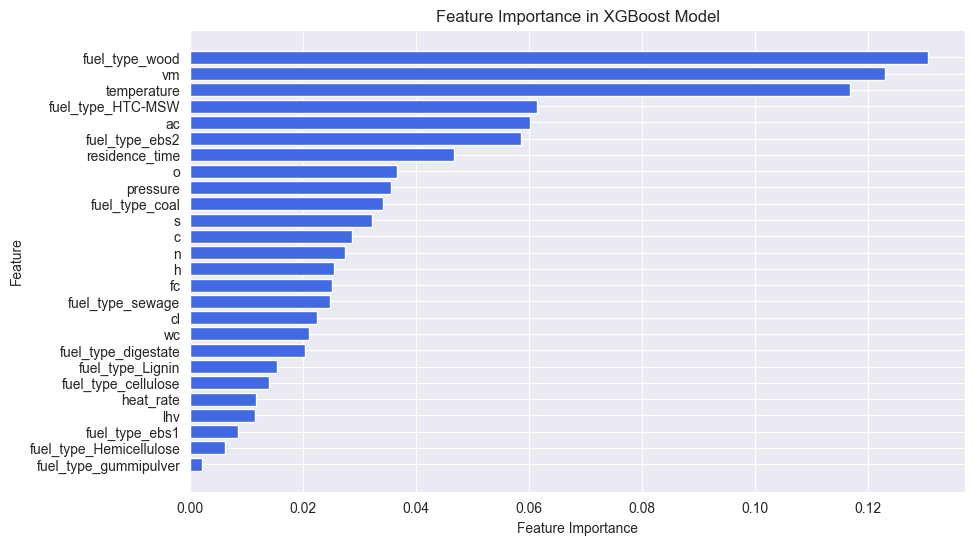

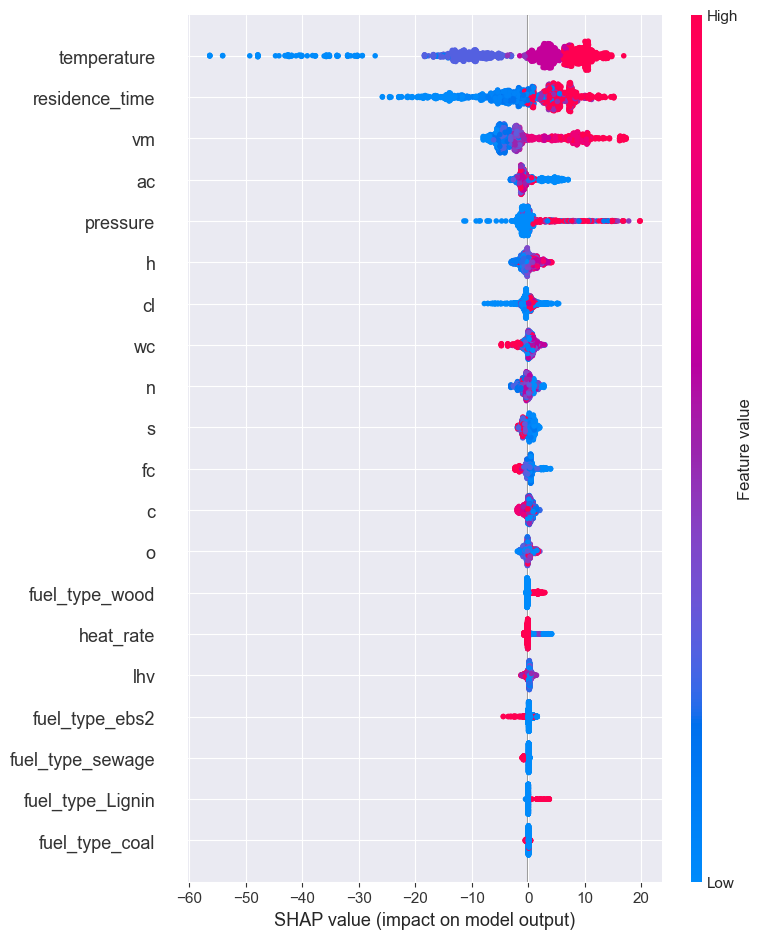


Best parameters (grid search): {'max_depth': np.int64(7), 'learning_rate': np.float64(0.07058474871672085), 'subsample': np.float64(0.6065515474221946), 'colsample_bytree': np.float64(0.7609766531163307), 'gamma': np.float64(0.778951455294309), 'alpha': np.float64(0.2840520205677538), 'min_child_weight': np.float64(2.2381964440190094), 'objective': 'reg:squarederror', 'eval_metric': 'rmse'}

Test Set Performance:
Test RMSE: 9.95828475822279
Test R-Squared: 0.7740818796157103


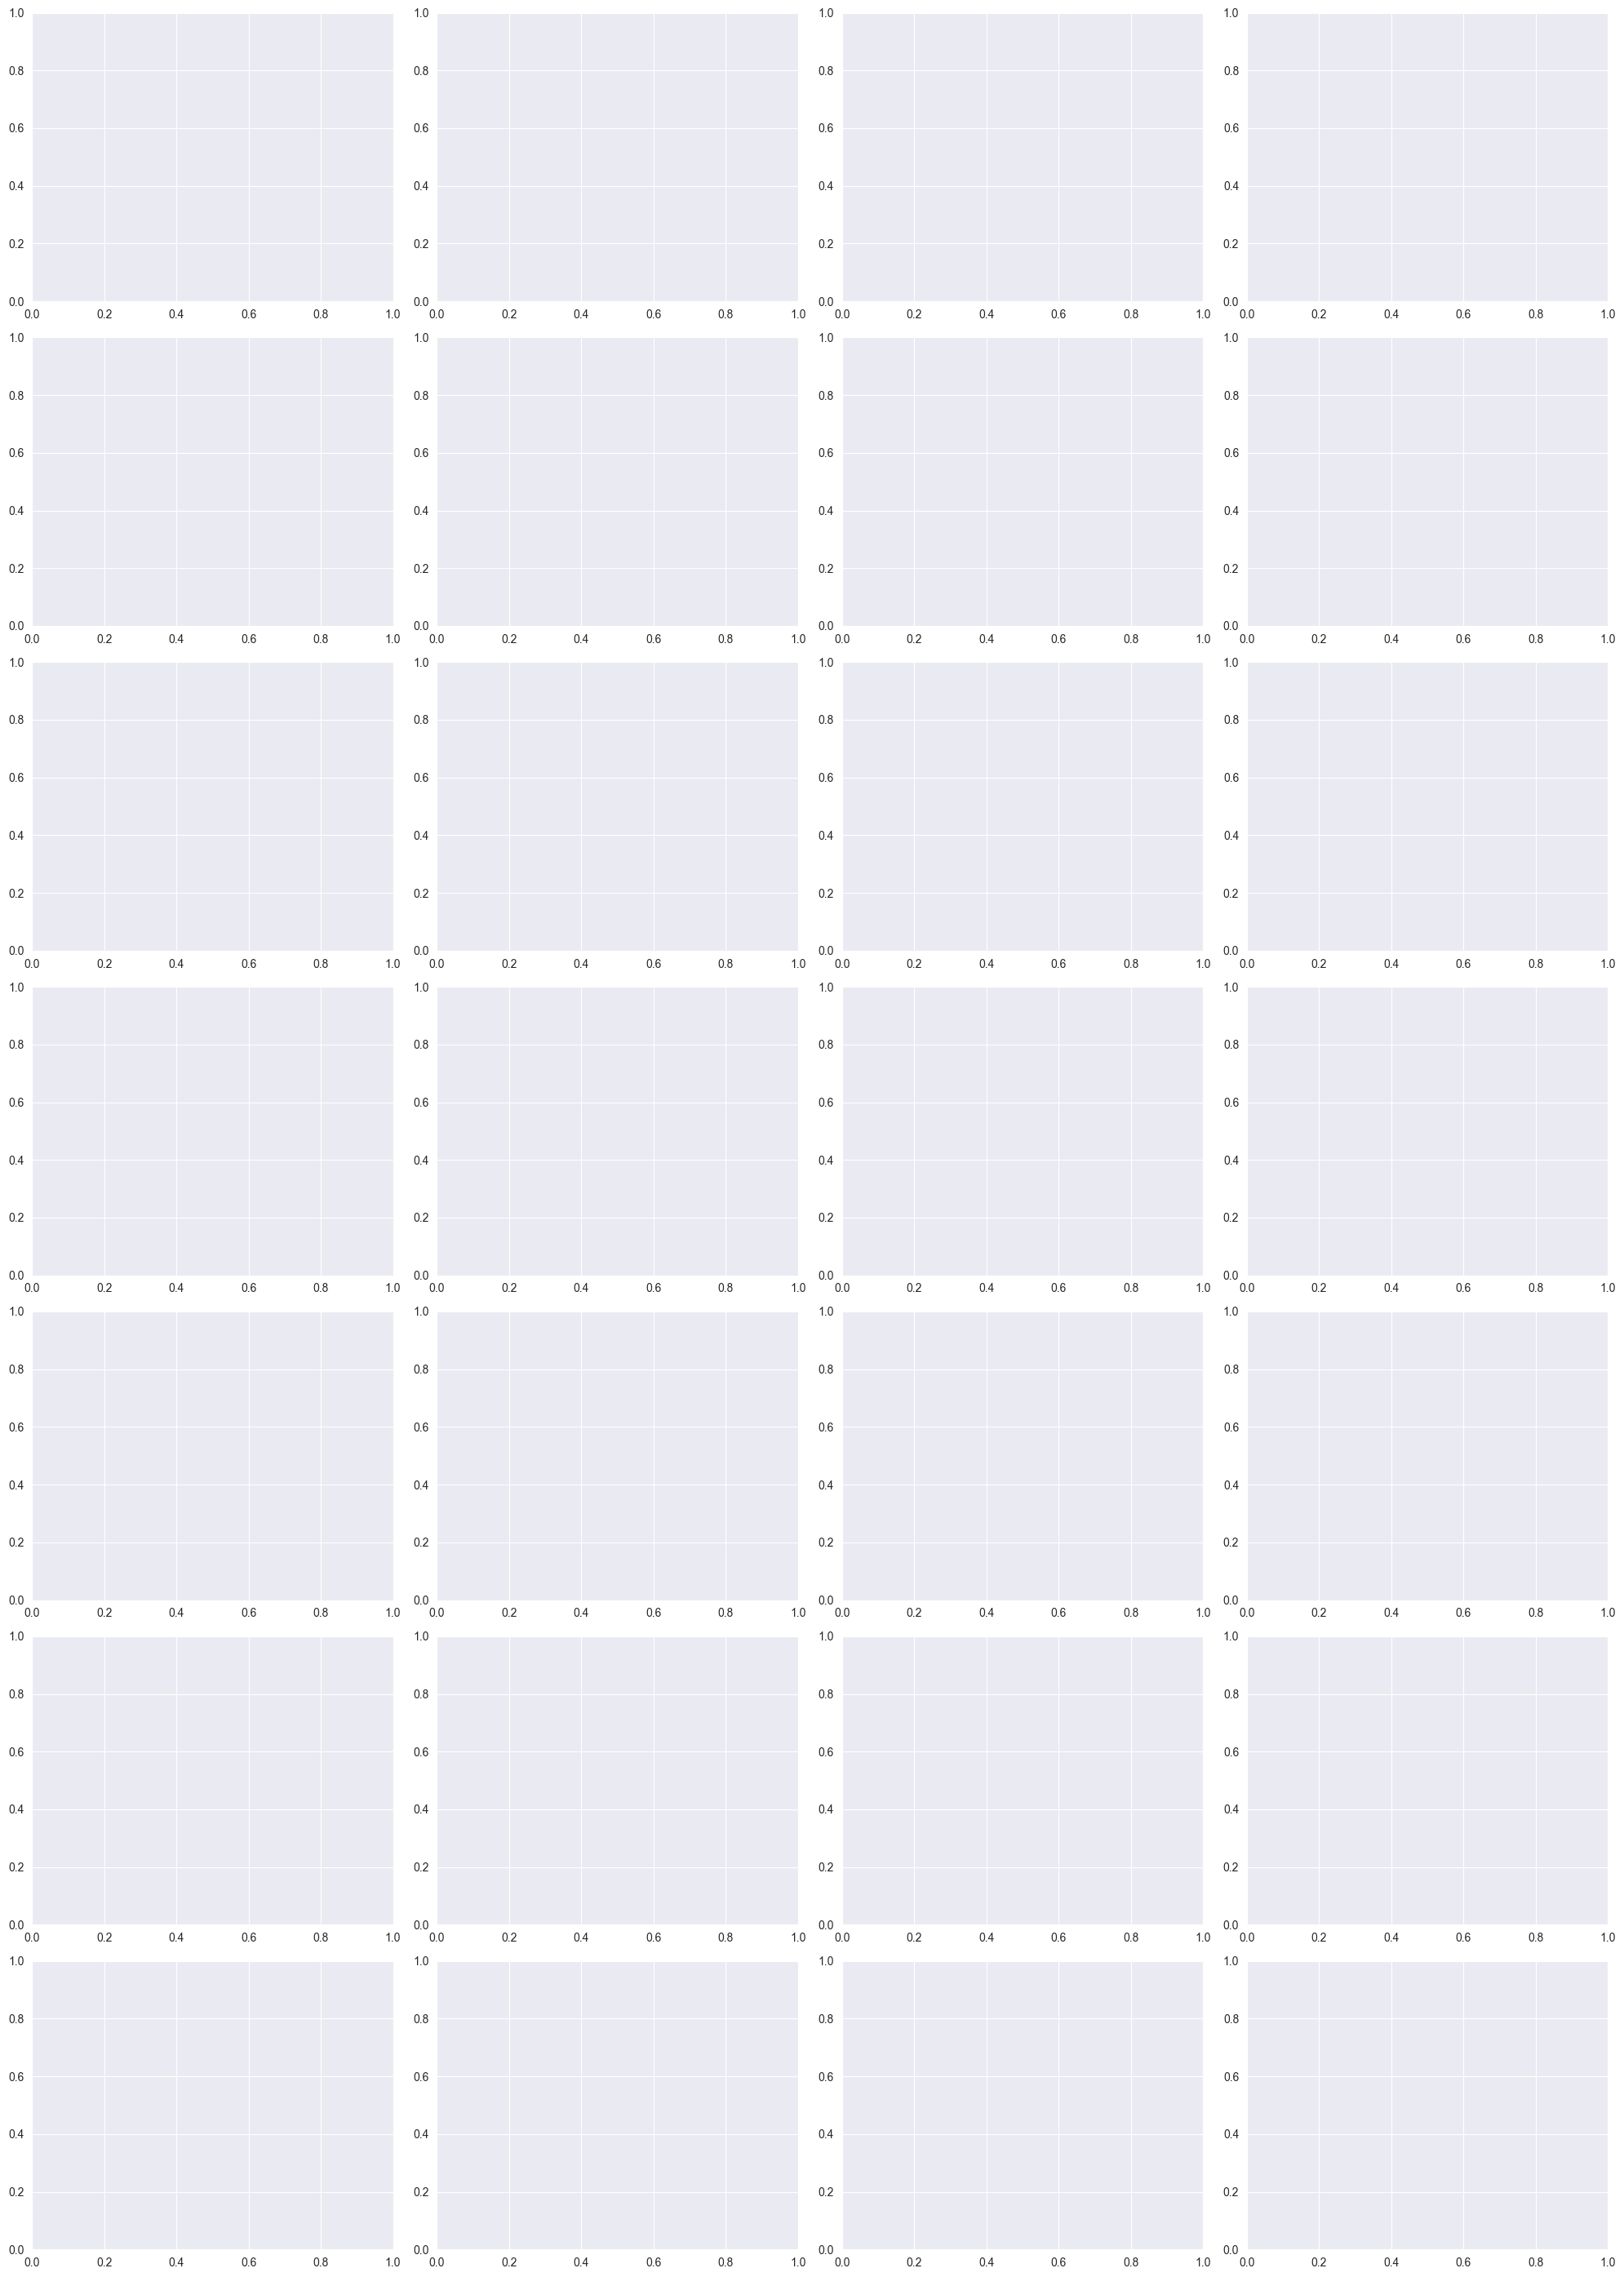

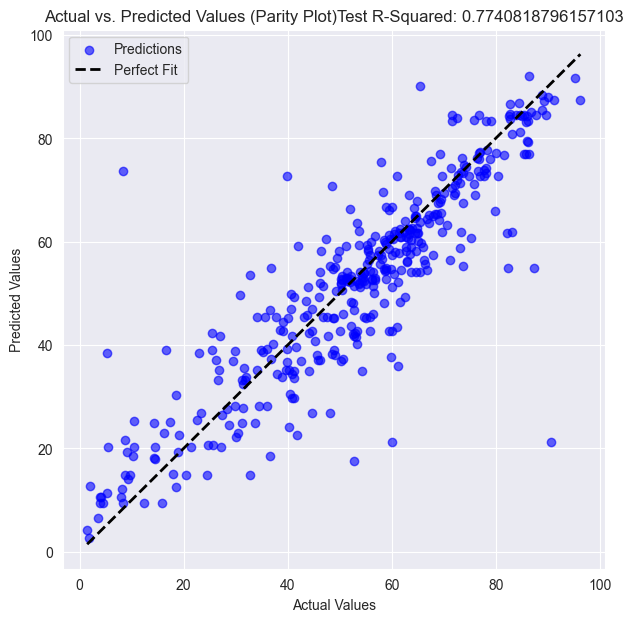

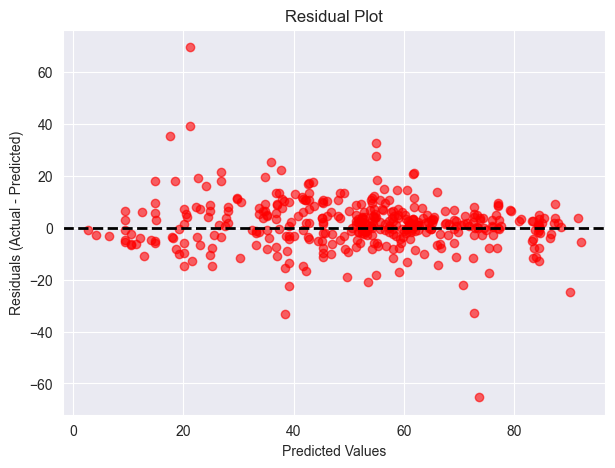

KeyError: 'hc'

<Figure size 700x500 with 0 Axes>

In [247]:
import shap
from xgboost import cv, DMatrix, train, XGBRegressor
from sklearn.model_selection import KFold, RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import graphviz
import os
import joblib

kf = KFold(n_splits=5, shuffle=True, random_state=42)
results = []


param_distributions = {
    'max_depth': [3,5, 7],
    'learning_rate': np.random.uniform(0.001, 0.2, 10),
    'subsample': np.random.uniform(0.6, 1.0, 10),
    'colsample_bytree': np.random.uniform(0.6, 1.0, 10),
    'gamma': np.random.uniform(0, 1, 10),
    'alpha': np.random.uniform(0, 1, 10),
    'min_child_weight': np.random.uniform(1, 3, 10),
}

# Number of random configurations and boosting rounds to test
n_iter = 50
boost_rounds = [100, 200, 300]

# Initialize placeholders for results
best_params = None
best_score = float('inf')
best_num_boost_round = None

print("Starting Random Search...")
for i in range(n_iter):
    # Randomly sample parameters
    params = {
        'max_depth': np.random.choice(param_distributions['max_depth']),
        'learning_rate': np.random.choice(param_distributions['learning_rate']),
        'subsample': np.random.choice(param_distributions['subsample']),
        'colsample_bytree': np.random.choice(param_distributions['colsample_bytree']),
        'gamma': np.random.choice(param_distributions['gamma']),
        'alpha': np.random.choice(param_distributions['alpha']),
        'min_child_weight': np.random.choice(param_distributions['min_child_weight']),
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
    }

    for num_boost_round in boost_rounds:
        print(f"Testing params: {params} with num_boost_round={num_boost_round}")
        fold_scores = []

        # Cross-validate using only the training set
        for train_index, val_index in kf.split(X_eng_train, y_eng_train):
            X_train_fold, X_val_fold = X_eng_train.iloc[train_index], X_eng_train.iloc[val_index]
            y_train_fold, y_val_fold = y_eng_train.iloc[train_index], y_eng_train.iloc[val_index]

            model = XGBRegressor(
                max_depth=params['max_depth'],
                learning_rate=params['learning_rate'],
                subsample=params['subsample'],
                objective='reg:squarederror',
                colsample_bytree=params['colsample_bytree'],
                gamma=params['gamma'],
                alpha=params['alpha'],
                min_child_weight=params['min_child_weight'],
                n_estimators=num_boost_round,
                eval_metric='rmse',  # Evaluation metric for validation
                random_state=42
            )

            model.fit(X_train_fold, y_train_fold, eval_set=[(X_val_fold, y_val_fold)], verbose=False)

            # Prediction and evaluation
            y_pred = model.predict(X_val_fold)
            rmse = mean_squared_error(y_val_fold, y_pred)
            fold_scores.append(rmse)

        # Calculate mean RMSE for the combination
        mean_rmse = np.mean(fold_scores)
        print(f"Mean RMSE: {mean_rmse} for params {params} and num_boost_round={num_boost_round}")

        # Save the best parameters and boosting rounds
        results.append((mean_rmse, params, num_boost_round))
        if mean_rmse < best_score:
            best_score = mean_rmse
            best_params = params
            best_num_boost_round = num_boost_round

# Train the final model on the entire training set with the best parameters
print("\nTraining final model with best parameters...")
final_model = XGBRegressor(
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    gamma=best_params['gamma'],
    alpha=best_params['alpha'],
    min_child_weight=best_params['min_child_weight'],
    objective='reg:squarederror',
    n_estimators=best_num_boost_round,
    eval_metric='rmse',
    random_state=42
)

final_model.fit(X_eng_train, y_eng_train)

# Evaluate on the test set
y_pred_test = final_model.predict(X_eng_test)
test_rmse = mean_squared_error(y_eng_test, y_pred_test) ** 0.5
test_r2 = r2_score(y_eng_test, y_pred_test)

graph = xgb.to_graphviz(final_model, num_trees=0, rankdir="LR")
# Render and view the updated tree
graph.render("xgb_tree_original_values", format="png", cleanup=True)
graph.view()

final_model.get_booster().dump_model('xgboost_tree_dump.txt')
joblib.dump(final_model, 'xgb.pkl')

importances = final_model.feature_importances_
feature_names = X_eng_train.columns

# Sort feature importance
sorted_idx = importances.argsort()[::-1]
sorted_features = [feature_names[i] for i in sorted_idx]

# Plot
plt.figure(figsize=(10, 6))
plt.barh(sorted_features, importances[sorted_idx], color='royalblue')
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importance in XGBoost Model")
plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.show()

explainer = shap.Explainer(final_model)
shap_values = explainer(X_eng_train)

# Visualize the SHAP summary plot
shap.summary_plot(shap_values, X_eng_train, feature_names=feature_names)

print(f"\nBest parameters (grid search): {best_params}")
print(f"\nTest Set Performance:")
print(f"Test RMSE: {test_rmse}")
print(f"Test R-Squared: {test_r2}")


# Determine the number of features
num_features = X_eng_train.shape[1]

# Define the grid dimensions for subplots (e.g., 3 rows x 4 columns for 12 features)
n_cols = 4
n_rows = int(np.ceil(num_features / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
axes = axes.flatten()

# Hide any unused subplots if the grid is larger than the number of features
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 7))
plt.scatter(y_eng_test, y_pred_test, color='blue', alpha=0.6, label='Predictions')
plt.plot([y_eng_test.min(), y_eng_test.max()], [y_eng_test.min(), y_eng_test.max()], 'k--', lw=2, label='Perfect Fit')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values (Parity Plot)' + f"Test R-Squared: {test_r2}")
plt.legend()
plt.grid(True)
plt.show()

y_pred_test = y_pred_test.flatten()

residuals = y_eng_test - y_pred_test

plt.figure(figsize=(7, 5))
plt.scatter(y_pred_test, residuals, color='red', alpha=0.6)
plt.axhline(y=0, color='black', linestyle='--', lw=2)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residual Plot')
plt.grid(True)
plt.show()

plt.figure(figsize=(7, 5))
plt.scatter(X_eng_test['hc'], y_pred_test, color='red', alpha=0.6)
plt.scatter(X_eng_test['hc'], y_eng_test, color='blue', alpha=0.6)
plt.axhline(y=0, color='black', linestyle='--', lw=2)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residual Plot')
plt.grid(True)
plt.show()

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
results = []


param_distributions = {
    'max_depth': [3,5, 7],
    'learning_rate': np.random.uniform(0.001, 0.2, 10),
    'subsample': np.random.uniform(0.6, 1.0, 10),
    'colsample_bytree': np.random.uniform(0.6, 1.0, 10),
    'gamma': np.random.uniform(0, 1, 10),
    'alpha': np.random.uniform(0, 1, 10),
    'min_child_weight': np.random.uniform(1, 3, 10),
}

# Number of random configurations and boosting rounds to test
n_iter = 50
boost_rounds = [100, 200, 300]

# Initialize placeholders for results
best_params = None
best_score = float('inf')
best_num_boost_round = None

print("Starting Random Search...")
for i in range(n_iter):
    # Randomly sample parameters
    params = {
        'max_depth': np.random.choice(param_distributions['max_depth']),
        'learning_rate': np.random.choice(param_distributions['learning_rate']),
        'subsample': np.random.choice(param_distributions['subsample']),
        'colsample_bytree': np.random.choice(param_distributions['colsample_bytree']),
        'gamma': np.random.choice(param_distributions['gamma']),
        'alpha': np.random.choice(param_distributions['alpha']),
        'min_child_weight': np.random.choice(param_distributions['min_child_weight']),
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
    }

    for num_boost_round in boost_rounds:
        print(f"Testing params: {params} with num_boost_round={num_boost_round}")
        fold_scores = []

        # Cross-validate using only the training set
        for train_index, val_index in kf.split(X_train_pca, y_eng_train):
            X_train_fold, X_val_fold = X_train_pca.iloc[train_index], X_train_pca.iloc[val_index]
            y_train_fold, y_val_fold = y_eng_train.iloc[train_index], y_eng_train.iloc[val_index]

            model = XGBRegressor(
                max_depth=params['max_depth'],
                learning_rate=params['learning_rate'],
                subsample=params['subsample'],
                objective='reg:squarederror',
                colsample_bytree=params['colsample_bytree'],
                gamma=params['gamma'],
                alpha=params['alpha'],
                min_child_weight=params['min_child_weight'],
                n_estimators=num_boost_round,
                eval_metric='rmse',  # Evaluation metric for validation
                random_state=42
            )

            model.fit(X_train_fold, y_train_fold, eval_set=[(X_val_fold, y_val_fold)], verbose=False)

            # Prediction and evaluation
            y_pred = model.predict(X_val_fold)
            rmse = mean_squared_error(y_val_fold, y_pred)
            fold_scores.append(rmse)

        # Calculate mean RMSE for the combination
        mean_rmse = np.mean(fold_scores)
        print(f"Mean RMSE: {mean_rmse} for params {params} and num_boost_round={num_boost_round}")

        # Save the best parameters and boosting rounds
        results.append((mean_rmse, params, num_boost_round))
        if mean_rmse < best_score:
            best_score = mean_rmse
            best_params = params
            best_num_boost_round = num_boost_round

# Train the final model on the entire training set with the best parameters
print("\nTraining final model with best parameters...")
final_model = XGBRegressor(
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    gamma=best_params['gamma'],
    alpha=best_params['alpha'],
    min_child_weight=best_params['min_child_weight'],
    objective='reg:squarederror',
    n_estimators=best_num_boost_round,
    eval_metric='rmse',
    random_state=42
)

final_model.fit(X_train_pca, y_eng_train)

# Evaluate on the test set
y_pred_test = final_model.predict(X_test_pca)
test_rmse = mean_squared_error(y_eng_test, y_pred_test) ** 0.5
test_r2 = r2_score(y_eng_test, y_pred_test)

graph = xgb.to_graphviz(final_model, num_trees=0, rankdir="LR")
# Render and view the updated tree
graph.render("xgb_tree_original_values", format="png", cleanup=True)
graph.view()

final_model.get_booster().dump_model('xgboost_tree_dump.txt')
joblib.dump(final_model, 'xgb.pkl')

importances = final_model.feature_importances_
feature_names = X_train_pca.columns

# Sort feature importance
sorted_idx = importances.argsort()[::-1]
sorted_features = [feature_names[i] for i in sorted_idx]

# Plot
plt.figure(figsize=(10, 6))
plt.barh(sorted_features, importances[sorted_idx], color='royalblue')
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importance in XGBoost Model")
plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.show()

explainer = shap.Explainer(final_model)
shap_values = explainer(X_train_pca)

# Visualize the SHAP summary plot
shap.summary_plot(shap_values, X_train_pca, feature_names=feature_names)

print(f"\nBest parameters (grid search): {best_params}")
print(f"\nTest Set Performance:")
print(f"Test RMSE: {test_rmse}")
print(f"Test R-Squared: {test_r2}")


# Determine the number of features
num_features = X_test_pca.shape[1]

# Define the grid dimensions for subplots (e.g., 3 rows x 4 columns for 12 features)
n_cols = 4
n_rows = int(np.ceil(num_features / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
axes = axes.flatten()

# Loop over each feature and plot actual vs. predicted values
for i, feature in enumerate(X_test_pca.columns):
    ax = axes[i]
    ax.scatter(X_test_pca[feature], y_eng_test, color='blue', alpha=0.5, label='Actual')
    ax.scatter(X_test_pca[feature], y_pred_test, color='red', alpha=0.5, label='Predicted')
    ax.set_xlabel(feature)
    ax.set_ylabel('Target')
    ax.legend()
    ax.set_title(f"Feature: {feature}")

# Hide any unused subplots if the grid is larger than the number of features
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 7))
plt.scatter(y_eng_test, y_pred_test, color='blue', alpha=0.6, label='Predictions')
plt.plot([y_eng_test.min(), y_eng_test.max()], [y_eng_test.min(), y_eng_test.max()], 'k--', lw=2, label='Perfect Fit')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values (Parity Plot)')
plt.legend()
plt.grid(True)
plt.show()

y_pred_test = y_pred_test.flatten()

residuals = y_eng_test - y_pred_test

plt.figure(figsize=(7, 5))
plt.scatter(y_pred_test, residuals, color='red', alpha=0.6)
plt.axhline(y=0, color='black', linestyle='--', lw=2)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residual Plot')
plt.grid(True)
plt.show()

plt.figure(figsize=(7, 5))
plt.scatter(X_test_pca['hc'], y_pred_test, color='red', alpha=0.6)
plt.scatter(X_test_pca['hc'], y_eng_test, color='blue', alpha=0.6)
plt.axhline(y=0, color='black', linestyle='--', lw=2)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residual Plot')
plt.grid(True)
plt.show()

## Best Performing Dataset
Features

In [226]:
import shap
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
import pandas as pd
import numpy as np
import xgboost as xgb

# Load data
data = pd.read_csv(r"C:\Users\demir\OneDrive\Desktop\MSc Thesis\Data\separate_samples\encoded_shuffled.csv")

# Feature Engineering
data['oh'] = data['o'] / data['h']
data['T_time'] = data['residence_time'] * data['temperature']
data['t_to_Tset'] = data['temperature'] / data['heat_rate']
data['VM/FC'] = data['vm'] / data['fc']
data['AC/FC'] = data['ac'] / data['fc']

# Drop unnecessary columns
data.drop(['h', 'o', 'c', 'wc', 'lhv', 'vm', 'ac', 'fc'], axis=1, inplace=True)
print('before outlier treatment', data.describe())
data = remove_outliers_zscore(data, 'devol_yield', threshold=2.5)
print('after outlier treatment' , data.describe())
# Define X and y
X_ratios = data.drop(['sample', 'devol_yield'], axis=1)
y_eng = data[['devol_yield']]  # Keep y as a DataFrame

# Handle missing values using KNN Imputer
imputer = KNNImputer(n_neighbors=3)
X_ratios = pd.DataFrame(imputer.fit_transform(X_ratios), columns=X_ratios.columns)
y_eng = pd.DataFrame(imputer.fit_transform(y_eng), columns=['devol_yield'])

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_ratios, y_eng, test_size=0.15, random_state=42)

# Standardize Features
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_ratios.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_ratios.columns)

# Check Final Shapes
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")

before outlier treatment        temperature  residence_time     pressure    heat_rate            n  \
count  1990.000000     1990.000000  1990.000000  1990.000000  1990.000000   
mean    804.517588        5.311809     2.479899   919.899497     1.672393   
std     195.916696        4.401299     4.043454   254.790187     1.056971   
min     200.000000        0.500000     0.500000    10.000000     0.269662   
25%     600.000000        1.000000     1.000000  1000.000000     0.900000   
50%     800.000000        5.000000     1.000000  1000.000000     1.783280   
75%    1000.000000       10.000000     1.000000  1000.000000     2.142543   
max    1200.000000       20.000000    20.000000  1000.000000     3.900000   

                 s           cl           hc           oc  devol_yield  \
count  1990.000000  1450.000000  1990.000000  1990.000000  1990.000000   
mean      0.594517     0.367320     1.404062     1.562463    52.140244   
std       0.698262     0.626146     0.342027     4.913049  

(975, 14) (975, 1)
           Feature  MI Score
12           VM/FC  0.446268
7               hc  0.445932
9               oh  0.444653
5                s  0.429271
4                n  0.410484
8               oc  0.377198
13           AC/FC  0.368936
10          T_time  0.337545
11       t_to_Tset  0.308929
0      temperature  0.294726
6               cl  0.239608
1   residence_time  0.115197
3        heat_rate  0.073540
2         pressure  0.035092


C:\Users\demir\PycharmProjects\volatile-predict\.venv\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Text(0.5, 1.0, 'MI Score vs. Features')

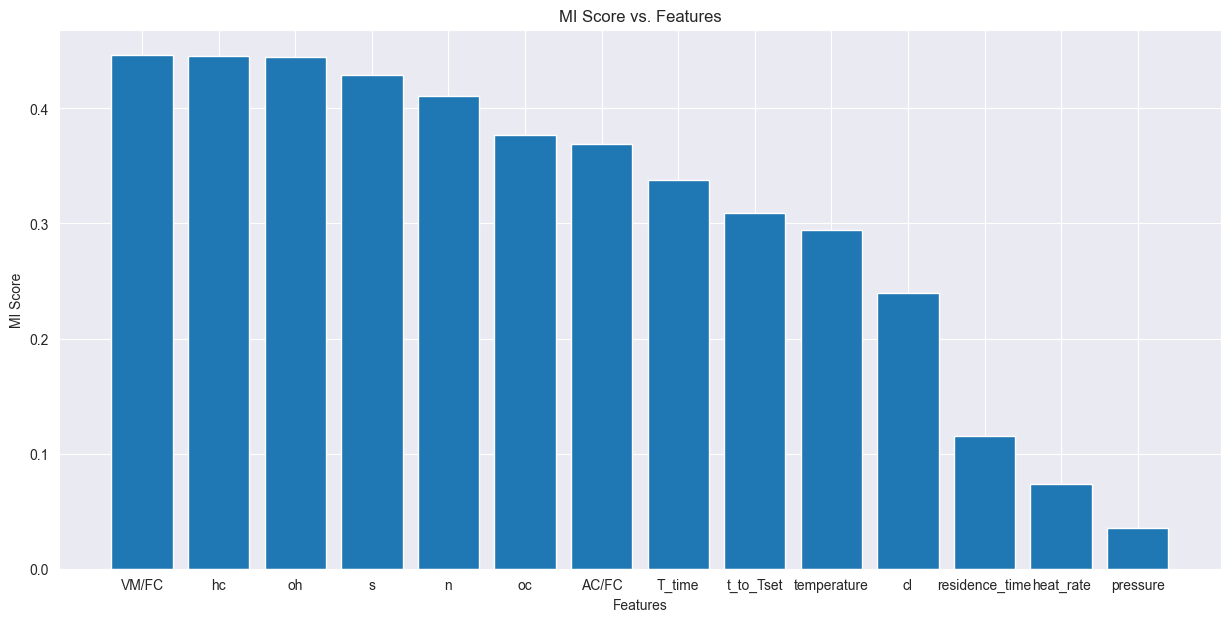

In [222]:
from sklearn.feature_selection import mutual_info_regression
print(X_ratios.shape, y_eng.shape)
mi_scores = mutual_info_regression(X_ratios, y_eng)

# Convert to a DataFrame for better visualization
mi_df = pd.DataFrame({'Feature': X_ratios.columns, 'MI Score': mi_scores})
mi_df = mi_df.sort_values(by='MI Score', ascending=False)

# Display results
print(mi_df)

plt.figure(figsize=(15, 7))
plt.bar(mi_df['Feature'], mi_df['MI Score'])
plt.xlabel('Features')
plt.ylabel('MI Score')
plt.title('MI Score vs. Features')


In [223]:
correlation_matrix = data.drop(['sample'], axis = 1).corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

ValueError: could not convert string to float: 'biomass'

In [224]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

# Compute VIF for X_eng_train
vif_results = calculate_vif(X_ratios.drop(['x0_biomass', 'x0_coal', 'x0_mix', 'x0_plastic'], axis=1))
print(vif_results)

KeyError: "['x0_biomass', 'x0_coal', 'x0_mix', 'x0_plastic'] not found in axis"

Starting Random Search...
Testing params: {'max_depth': np.int64(7), 'learning_rate': np.float64(0.15707696753271982), 'subsample': np.float64(0.6393888575901847), 'colsample_bytree': np.float64(0.6202174208549772), 'gamma': np.float64(0.2800436737319746), 'alpha': np.float64(0.6855237255323596), 'min_child_weight': np.float64(1.9234153401057357), 'objective': 'reg:squarederror', 'eval_metric': 'rmse'} with num_boost_round=100
Mean RMSE: 150.72687835693358 for params {'max_depth': np.int64(7), 'learning_rate': np.float64(0.15707696753271982), 'subsample': np.float64(0.6393888575901847), 'colsample_bytree': np.float64(0.6202174208549772), 'gamma': np.float64(0.2800436737319746), 'alpha': np.float64(0.6855237255323596), 'min_child_weight': np.float64(1.9234153401057357), 'objective': 'reg:squarederror', 'eval_metric': 'rmse'} and num_boost_round=100
Testing params: {'max_depth': np.int64(7), 'learning_rate': np.float64(0.15707696753271982), 'subsample': np.float64(0.6393888575901847), 'c

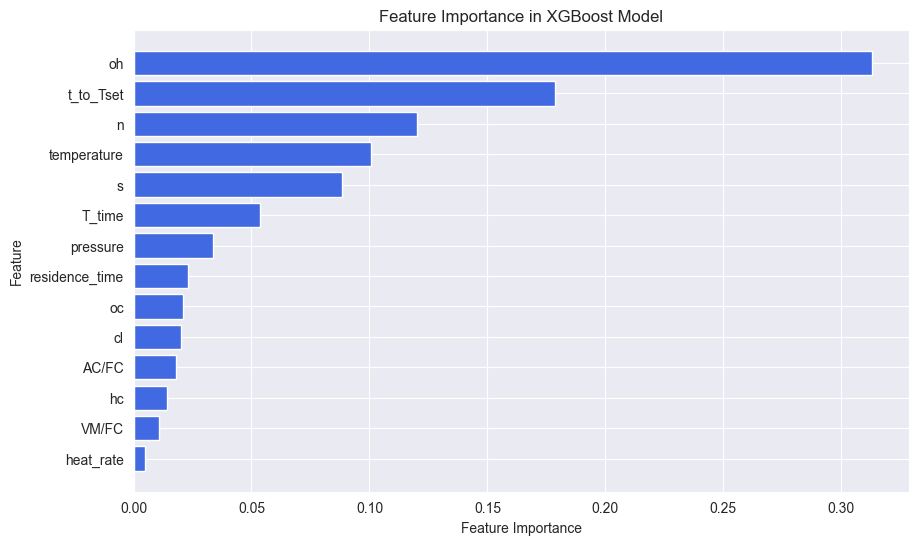

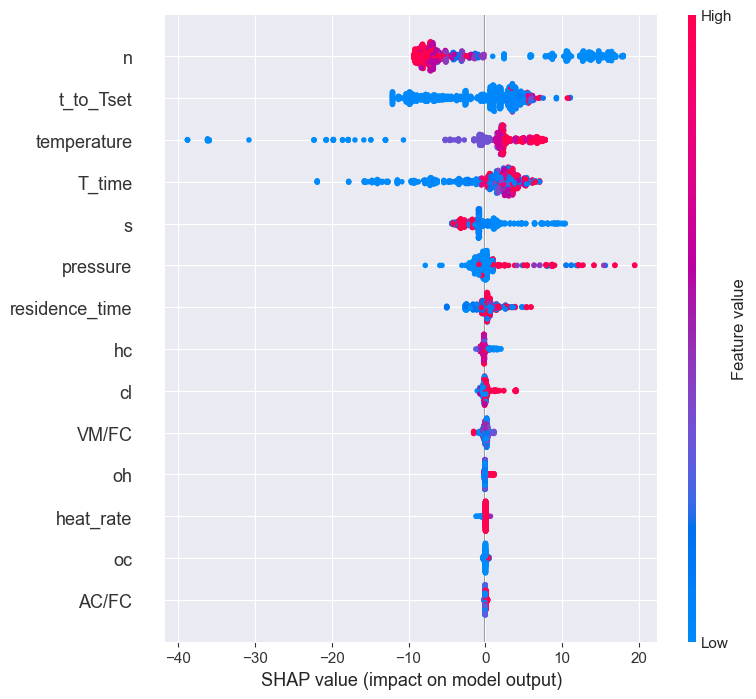


Best parameters (grid search): {'max_depth': np.int64(5), 'learning_rate': np.float64(0.06645148871306657), 'subsample': np.float64(0.6393888575901847), 'colsample_bytree': np.float64(0.9693636202424554), 'gamma': np.float64(0.6288982979281653), 'alpha': np.float64(0.1300597867513188), 'min_child_weight': np.float64(1.8039041456271472), 'objective': 'reg:squarederror', 'eval_metric': 'rmse'}

Test Set Performance:
Test RMSE: 106.36469268798828
Test R-Squared: 0.7703617811203003


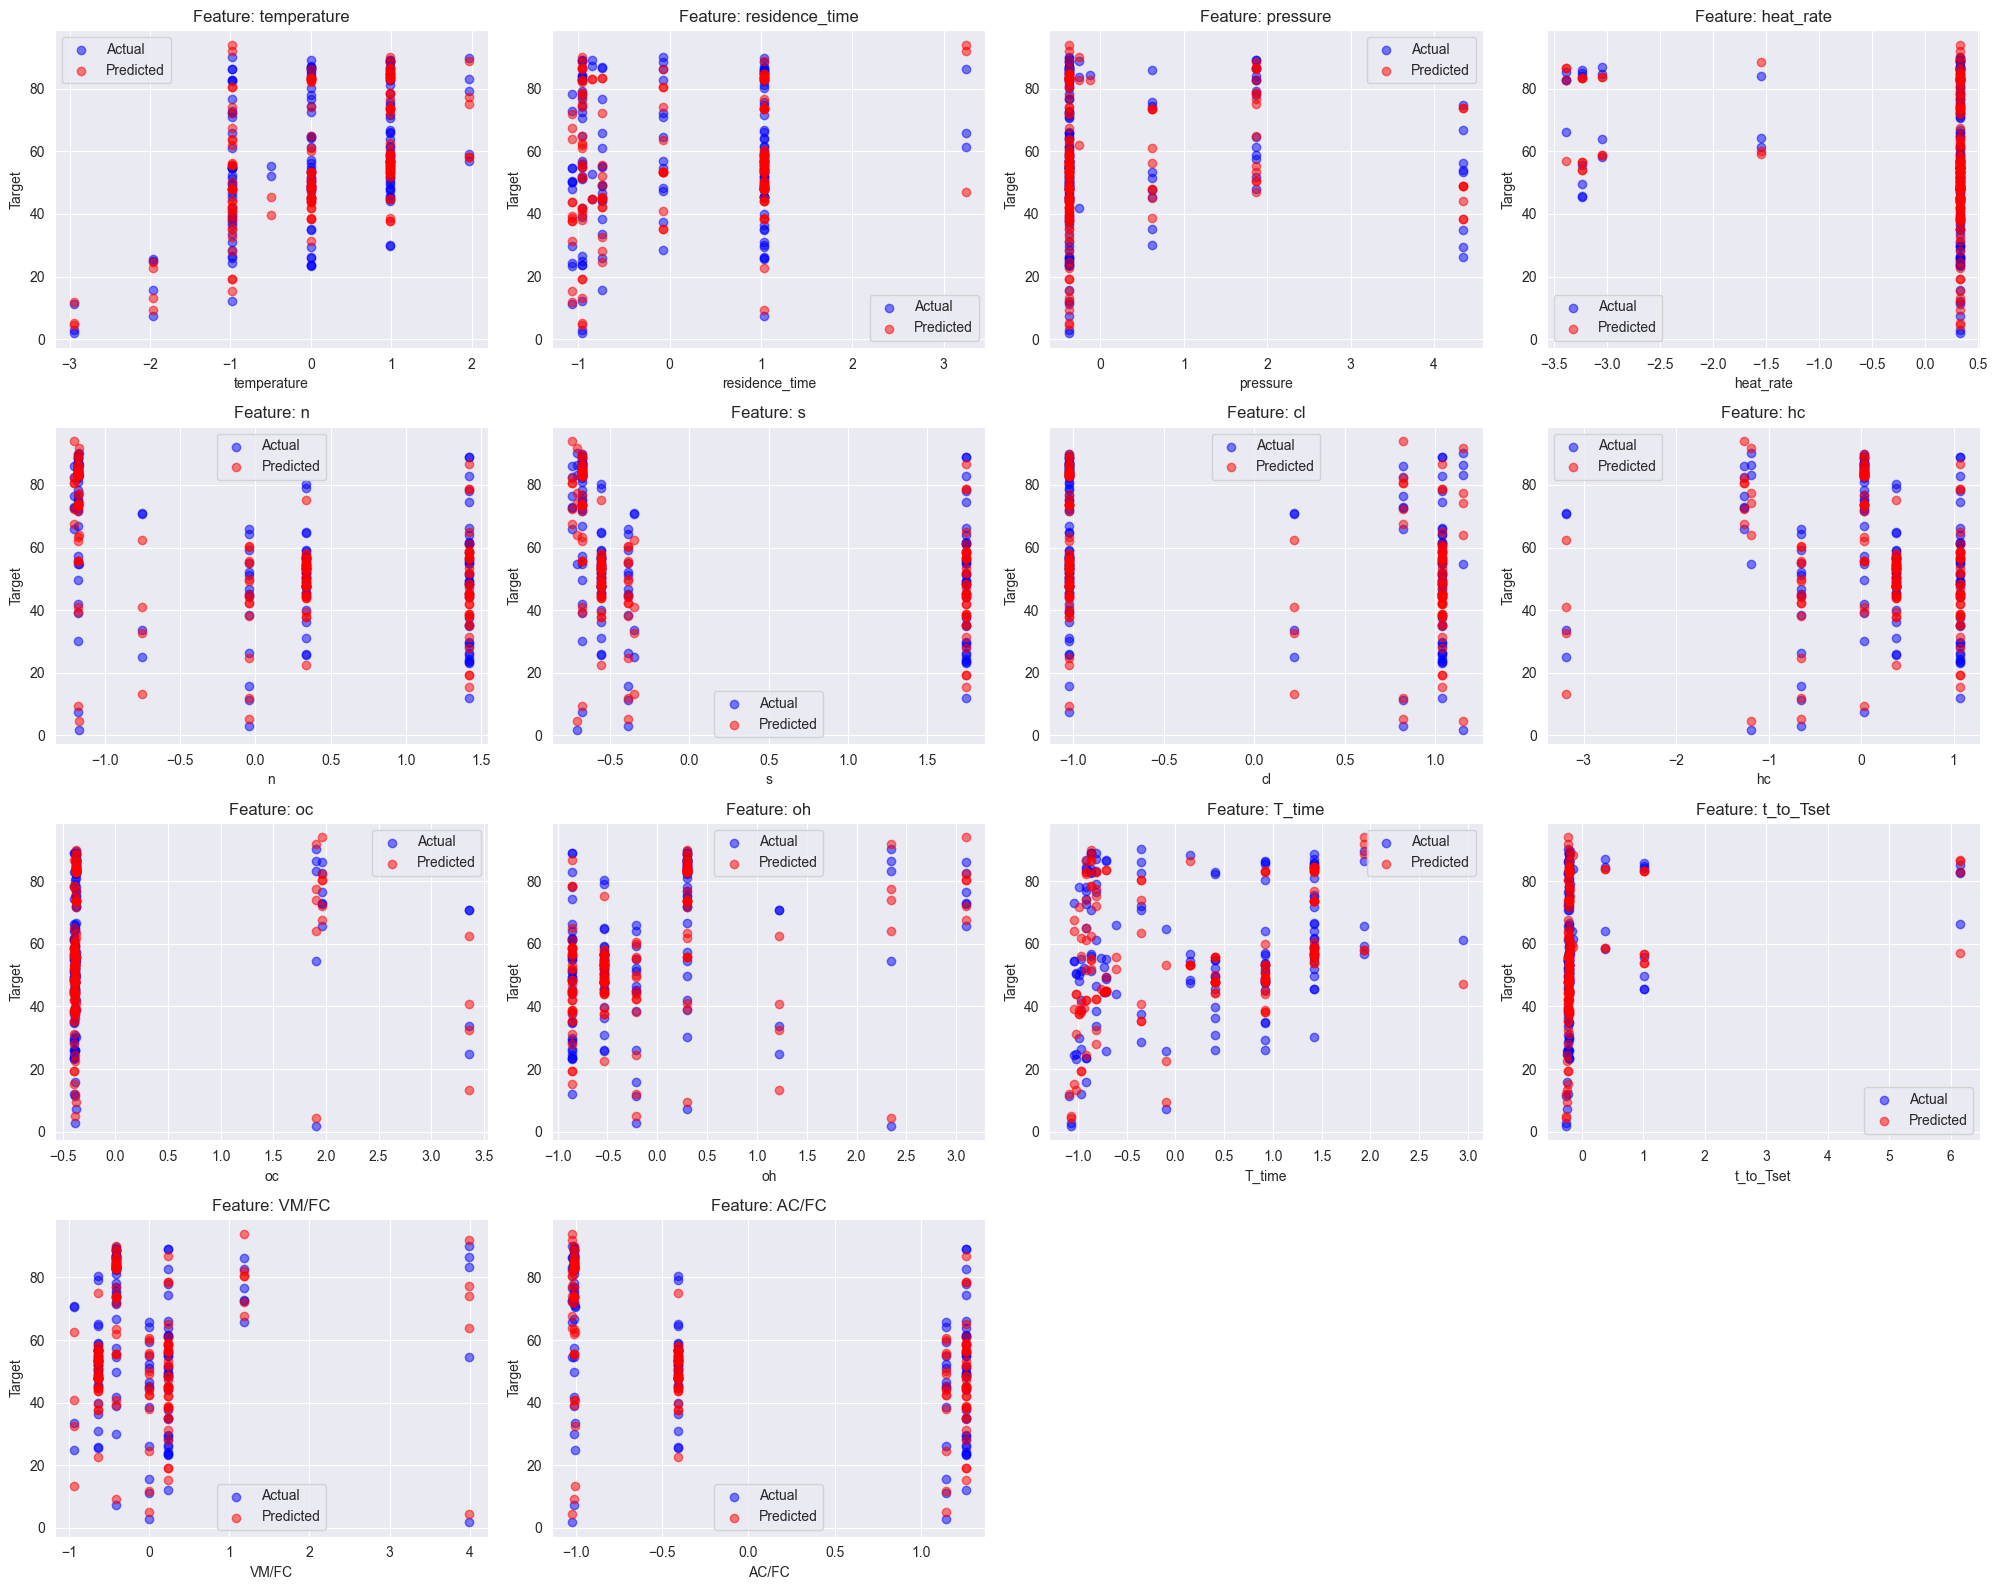

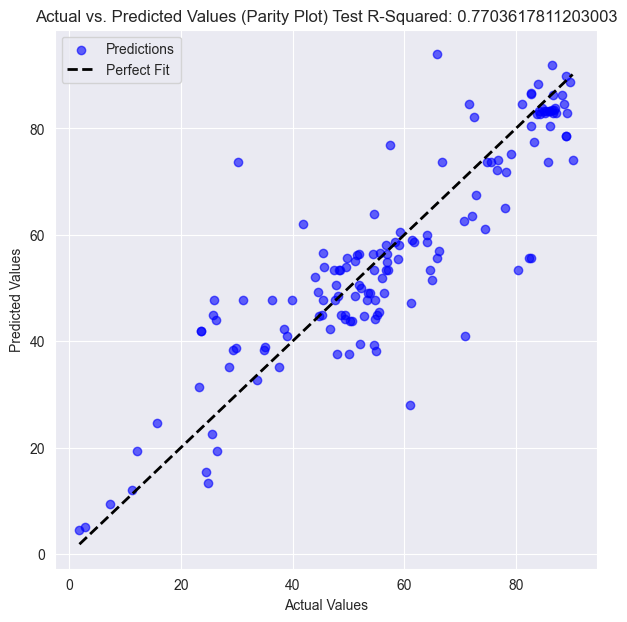

ValueError: Unable to coerce to Series, length must be 1: given 147

In [225]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
results = []


param_distributions = {
    'max_depth': [3,5, 7],
    'learning_rate': np.random.uniform(0.001, 0.2, 10),
    'subsample': np.random.uniform(0.6, 1.0, 10),
    'colsample_bytree': np.random.uniform(0.6, 1.0, 10),
    'gamma': np.random.uniform(0, 1, 10),
    'alpha': np.random.uniform(0, 1, 10),
    'min_child_weight': np.random.uniform(1, 3, 10),
}

# Number of random configurations and boosting rounds to test
n_iter = 50
boost_rounds = [100, 200, 300]

# Initialize placeholders for results
best_params = None
best_score = float('inf')
best_num_boost_round = None

print("Starting Random Search...")
for i in range(n_iter):
    # Randomly sample parameters
    params = {
        'max_depth': np.random.choice(param_distributions['max_depth']),
        'learning_rate': np.random.choice(param_distributions['learning_rate']),
        'subsample': np.random.choice(param_distributions['subsample']),
        'colsample_bytree': np.random.choice(param_distributions['colsample_bytree']),
        'gamma': np.random.choice(param_distributions['gamma']),
        'alpha': np.random.choice(param_distributions['alpha']),
        'min_child_weight': np.random.choice(param_distributions['min_child_weight']),
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
    }

    for num_boost_round in boost_rounds:
        print(f"Testing params: {params} with num_boost_round={num_boost_round}")
        fold_scores = []

        # Cross-validate using only the training set
        for train_index, val_index in kf.split(X_train, y_train):
            X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
            y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

            model = XGBRegressor(
                max_depth=params['max_depth'],
                learning_rate=params['learning_rate'],
                subsample=params['subsample'],
                objective='reg:squarederror',
                colsample_bytree=params['colsample_bytree'],
                gamma=params['gamma'],
                alpha=params['alpha'],
                min_child_weight=params['min_child_weight'],
                n_estimators=num_boost_round,
                eval_metric='rmse',  # Evaluation metric for validation
                random_state=42
            )

            model.fit(X_train_fold, y_train_fold, eval_set=[(X_val_fold, y_val_fold)], verbose=False)

            # Prediction and evaluation
            y_pred = model.predict(X_val_fold)
            rmse = mean_squared_error(y_val_fold, y_pred)
            fold_scores.append(rmse)

        # Calculate mean RMSE for the combination
        mean_rmse = np.mean(fold_scores)
        print(f"Mean RMSE: {mean_rmse} for params {params} and num_boost_round={num_boost_round}")

        # Save the best parameters and boosting rounds
        results.append((mean_rmse, params, num_boost_round))
        if mean_rmse < best_score:
            best_score = mean_rmse
            best_params = params
            best_num_boost_round = num_boost_round

# Train the final model on the entire training set with the best parameters
print("\nTraining final model with best parameters...")
final_model = XGBRegressor(
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    gamma=best_params['gamma'],
    alpha=best_params['alpha'],
    min_child_weight=best_params['min_child_weight'],
    objective='reg:squarederror',
    n_estimators=best_num_boost_round,
    eval_metric='rmse',
    random_state=42
)

final_model.fit(X_train, y_train)

# Evaluate on the test set
y_pred_test = final_model.predict(X_test)
test_rmse = mean_squared_error(y_test, y_pred_test)
test_r2 = r2_score(y_test, y_pred_test)


importances = final_model.feature_importances_
feature_names = X_train.columns

# Sort feature importance
sorted_idx = importances.argsort()[::-1]
sorted_features = [feature_names[i] for i in sorted_idx]

# Plot
plt.figure(figsize=(10, 6))
plt.barh(sorted_features, importances[sorted_idx], color='royalblue')
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importance in XGBoost Model")
plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.show()

explainer = shap.Explainer(final_model)
shap_values = explainer(X_train)

# Visualize the SHAP summary plot
shap.summary_plot(shap_values, X_train, feature_names=feature_names)

print(f"\nBest parameters (grid search): {best_params}")
print(f"\nTest Set Performance:")
print(f"Test RMSE: {test_rmse}")
print(f"Test R-Squared: {test_r2}")


# Determine the number of features
num_features = X_test.shape[1]

# Define the grid dimensions for subplots (e.g., 3 rows x 4 columns for 12 features)
n_cols = 4
n_rows = int(np.ceil(num_features / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
axes = axes.flatten()

# Loop over each feature and plot actual vs. predicted values
for i, feature in enumerate(X_test.columns):
    ax = axes[i]
    ax.scatter(X_test[feature], y_test, color='blue', alpha=0.5, label='Actual')
    ax.scatter(X_test[feature], y_pred_test, color='red', alpha=0.5, label='Predicted')
    ax.set_xlabel(feature)
    ax.set_ylabel('Target')
    ax.legend()
    ax.set_title(f"Feature: {feature}")

# Hide any unused subplots if the grid is larger than the number of features
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 7))
plt.scatter(y_test, y_pred_test, color='blue', alpha=0.6, label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Perfect Fit')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values (Parity Plot) ' + f"Test R-Squared: {test_r2}")
plt.legend()
plt.grid(True)
plt.show()

y_pred_test = y_pred_test.flatten()

residuals = y_test - y_pred_test

plt.figure(figsize=(7, 5))
plt.scatter(y_pred_test, residuals, color='red', alpha=0.6)
plt.axhline(y=0, color='black', linestyle='--', lw=2)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residual Plot')
plt.grid(True)
plt.show()

plt.figure(figsize=(7, 5))
plt.scatter(X_test['hc'], y_pred_test, color='red', alpha=0.6)
plt.scatter(X_test['hc'], y_test, color='blue', alpha=0.6)
plt.axhline(y=0, color='black', linestyle='--', lw=2)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residual Plot')
plt.grid(True)
plt.show()

In [204]:
import joblib
joblib.dump(final_model, r'C:\Users\demir\OneDrive\Desktop\MSc Thesis\Data\separate_samples\xgb_encoded_shuffled_zscore2.pkl')

['C:\\Users\\demir\\OneDrive\\Desktop\\MSc Thesis\\Data\\separate_samples\\xgb_encoded_shuffled.pkl']

Starting Random Search...
Testing params: {'n_estimators': np.int64(100), 'max_depth': np.int64(10), 'min_samples_split': np.int64(2), 'min_samples_leaf': np.int64(4), 'random_state': 42}
Mean RMSE: 125.13806106968954 for params {'n_estimators': np.int64(100), 'max_depth': np.int64(10), 'min_samples_split': np.int64(2), 'min_samples_leaf': np.int64(4), 'random_state': 42}
Testing params: {'n_estimators': np.int64(50), 'max_depth': np.int64(15), 'min_samples_split': np.int64(5), 'min_samples_leaf': np.int64(4), 'random_state': 42}
Mean RMSE: 124.82519718059652 for params {'n_estimators': np.int64(50), 'max_depth': np.int64(15), 'min_samples_split': np.int64(5), 'min_samples_leaf': np.int64(4), 'random_state': 42}
Testing params: {'n_estimators': np.int64(200), 'max_depth': np.int64(5), 'min_samples_split': np.int64(5), 'min_samples_leaf': np.int64(1), 'random_state': 42}
Mean RMSE: 159.83856880554802 for params {'n_estimators': np.int64(200), 'max_depth': np.int64(5), 'min_samples_split

C:\Users\demir\PycharmProjects\volatile-predict\.venv\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


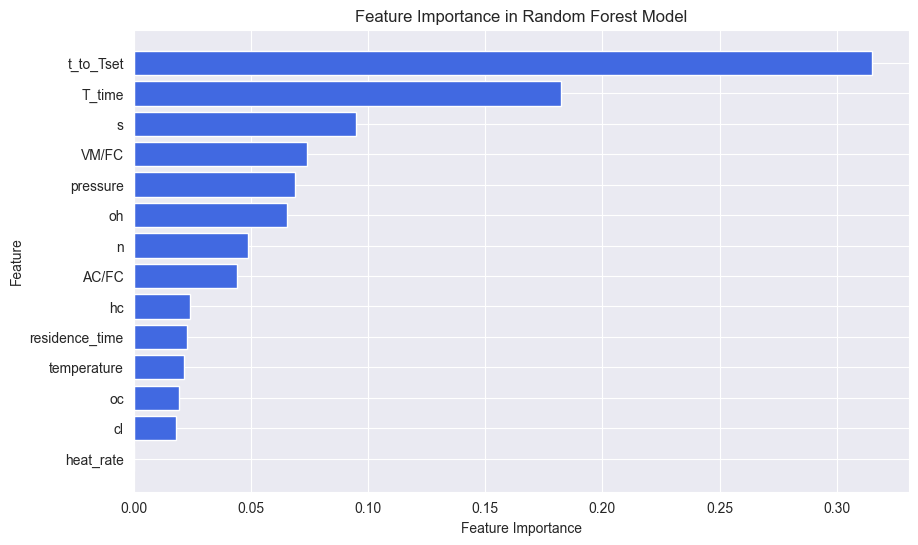

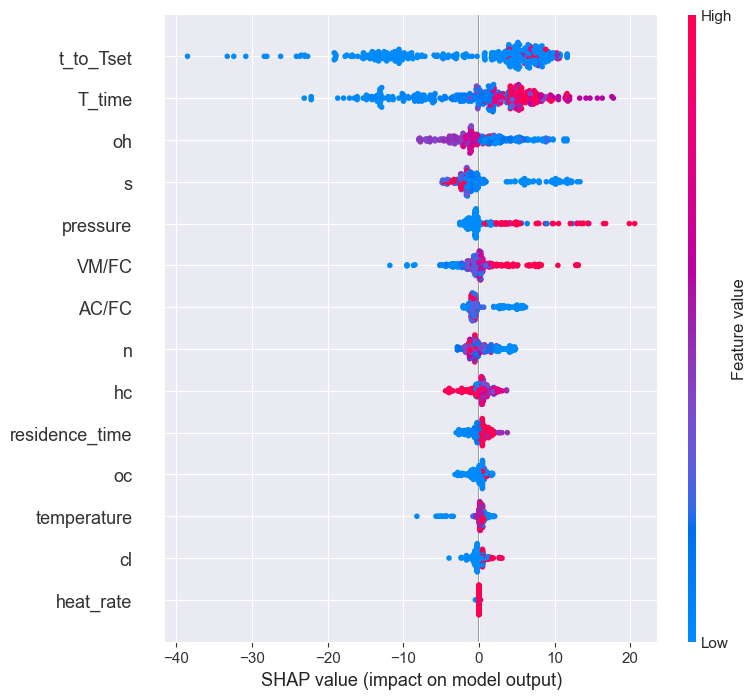

In [124]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

# Define cross-validation strategy
kf = KFold(n_splits=5, shuffle=True, random_state=42)
results = []

# Hyperparameter search space for Random Forest
param_distributions = {
    'n_estimators': [50, 100, 200],  # Number of trees
    'max_depth': [5, 10, 15],  # Tree depth
    'min_samples_split': [2, 5, 10],  # Minimum samples per split
    'min_samples_leaf': [1, 2, 4]  # Minimum samples per leaf
}

y_train=pd.DataFrame(y_train.values.ravel())
y_test=pd.DataFrame(y_test.values.ravel())
n_iter = 20
best_params = None
best_score = float('inf')

print("Starting Random Search...")
for i in range(n_iter):
    # Randomly sample parameters
    params = {
        'n_estimators': np.random.choice(param_distributions['n_estimators']),
        'max_depth': np.random.choice(param_distributions['max_depth']),
        'min_samples_split': np.random.choice(param_distributions['min_samples_split']),
        'min_samples_leaf': np.random.choice(param_distributions['min_samples_leaf']),
        'random_state': 42
    }

    print(f"Testing params: {params}")
    fold_scores = []
    # Cross-validation
    for train_index, val_index in kf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

        # Convert y_train_fold to 1D array for fitting the model
        y_train_fold = y_train_fold.values.ravel()
        y_val_fold = y_val_fold.values.ravel()

        model = RandomForestRegressor(**params)
        model.fit(X_train_fold, y_train_fold)

        # Prediction and evaluation
        y_pred = model.predict(X_val_fold)
        rmse = mean_squared_error(y_val_fold, y_pred)  # RMSE
        fold_scores.append(rmse)

    mean_rmse = np.mean(fold_scores)
    print(f"Mean RMSE: {mean_rmse} for params {params}")

    # Save the best parameters
    results.append((mean_rmse, params))
    if mean_rmse < best_score:
        best_score = mean_rmse
        best_params = params

# Train the final model on the entire dataset
print("\nTraining final model with best parameters...")
final_model = RandomForestRegressor(**best_params)
final_model.fit(X_train, y_train)

# Evaluate on the test set
y_pred_test = final_model.predict(X_test)
test_rmse = mean_squared_error(y_test, y_pred_test)
test_r2 = r2_score(y_test, y_pred_test)

# Feature Importance Plot
importances = final_model.feature_importances_
feature_names = X_train.columns

sorted_idx = np.argsort(importances)[::-1]
sorted_features = [feature_names[i] for i in sorted_idx]

plt.figure(figsize=(10, 6))
plt.barh(sorted_features, importances[sorted_idx], color='royalblue')
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importance in Random Forest Model")
plt.gca().invert_yaxis()
plt.show()

# SHAP Explanation
explainer = shap.Explainer(final_model)
# SHAP Explanation
shap_values = explainer.shap_values(X_test)

# SHAP Summary Plot
shap.summary_plot(shap_values, X_test)




Starting Random Search...
Testing params: {'max_depth': np.int64(7), 'learning_rate': np.float64(0.06461267515913392), 'subsample': np.float64(0.9524492872361665), 'colsample_bytree': np.float64(0.8495625576419111), 'gamma': np.float64(0.5948816981722158), 'alpha': np.float64(0.7183970276548197), 'min_child_weight': np.float64(1.6310582957400739), 'objective': 'reg:squarederror', 'eval_metric': 'rmse'} with num_boost_round=100
Mean RMSE: 112.30638580322265 for params {'max_depth': np.int64(7), 'learning_rate': np.float64(0.06461267515913392), 'subsample': np.float64(0.9524492872361665), 'colsample_bytree': np.float64(0.8495625576419111), 'gamma': np.float64(0.5948816981722158), 'alpha': np.float64(0.7183970276548197), 'min_child_weight': np.float64(1.6310582957400739), 'objective': 'reg:squarederror', 'eval_metric': 'rmse'} and num_boost_round=100
Testing params: {'max_depth': np.int64(7), 'learning_rate': np.float64(0.06461267515913392), 'subsample': np.float64(0.9524492872361665), 'c

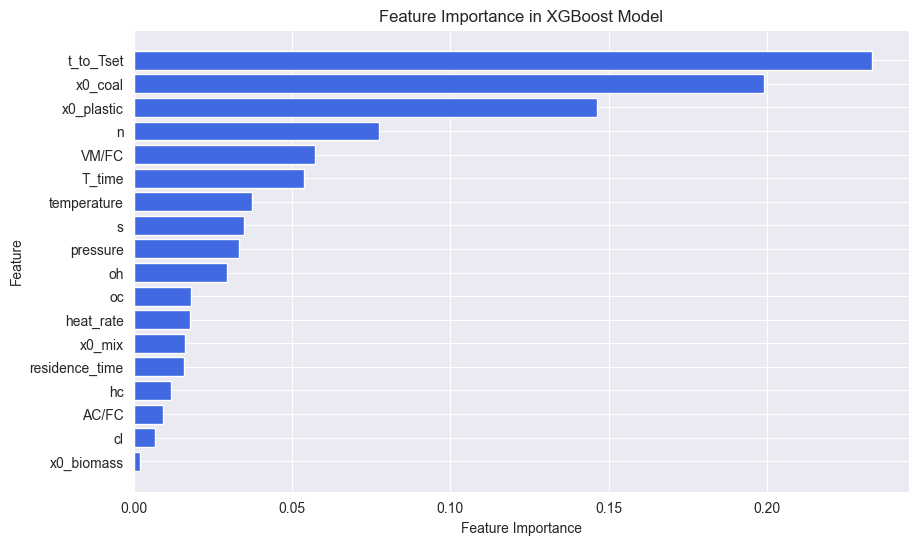

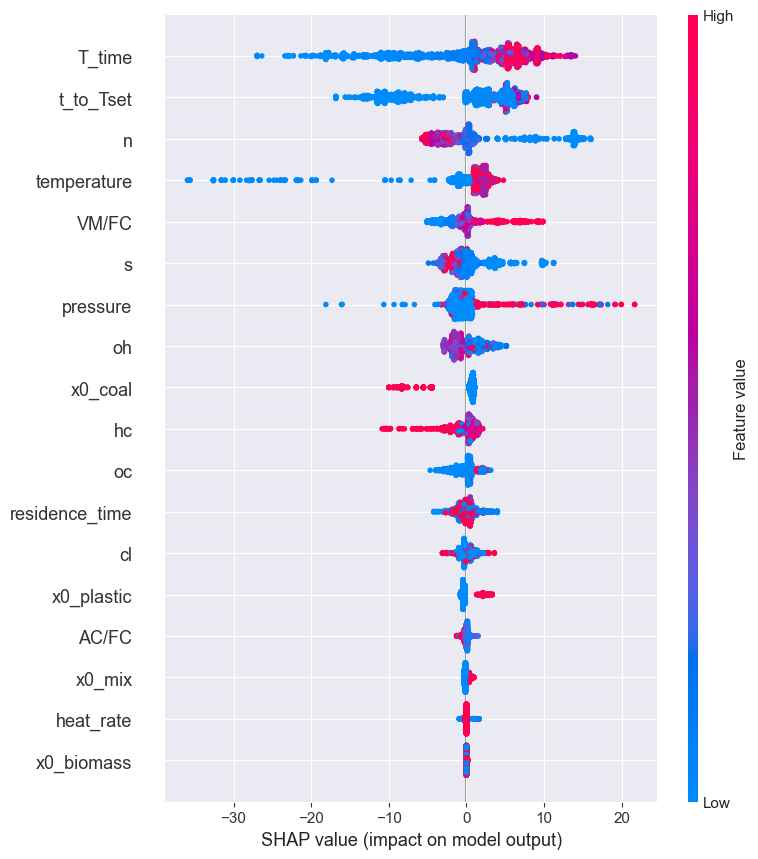


Best parameters (grid search): {'max_depth': np.int64(3), 'learning_rate': np.float64(0.14954709357964285), 'subsample': np.float64(0.8851121564780535), 'colsample_bytree': np.float64(0.8938480716318628), 'gamma': np.float64(0.5181429429958778), 'alpha': np.float64(0.5269433619077455), 'min_child_weight': np.float64(1.4925626784648165), 'objective': 'reg:squarederror', 'eval_metric': 'rmse'}

Test Set Performance:
Test RMSE: 92.10053253173828
Test R-Squared: 0.8183770179748535


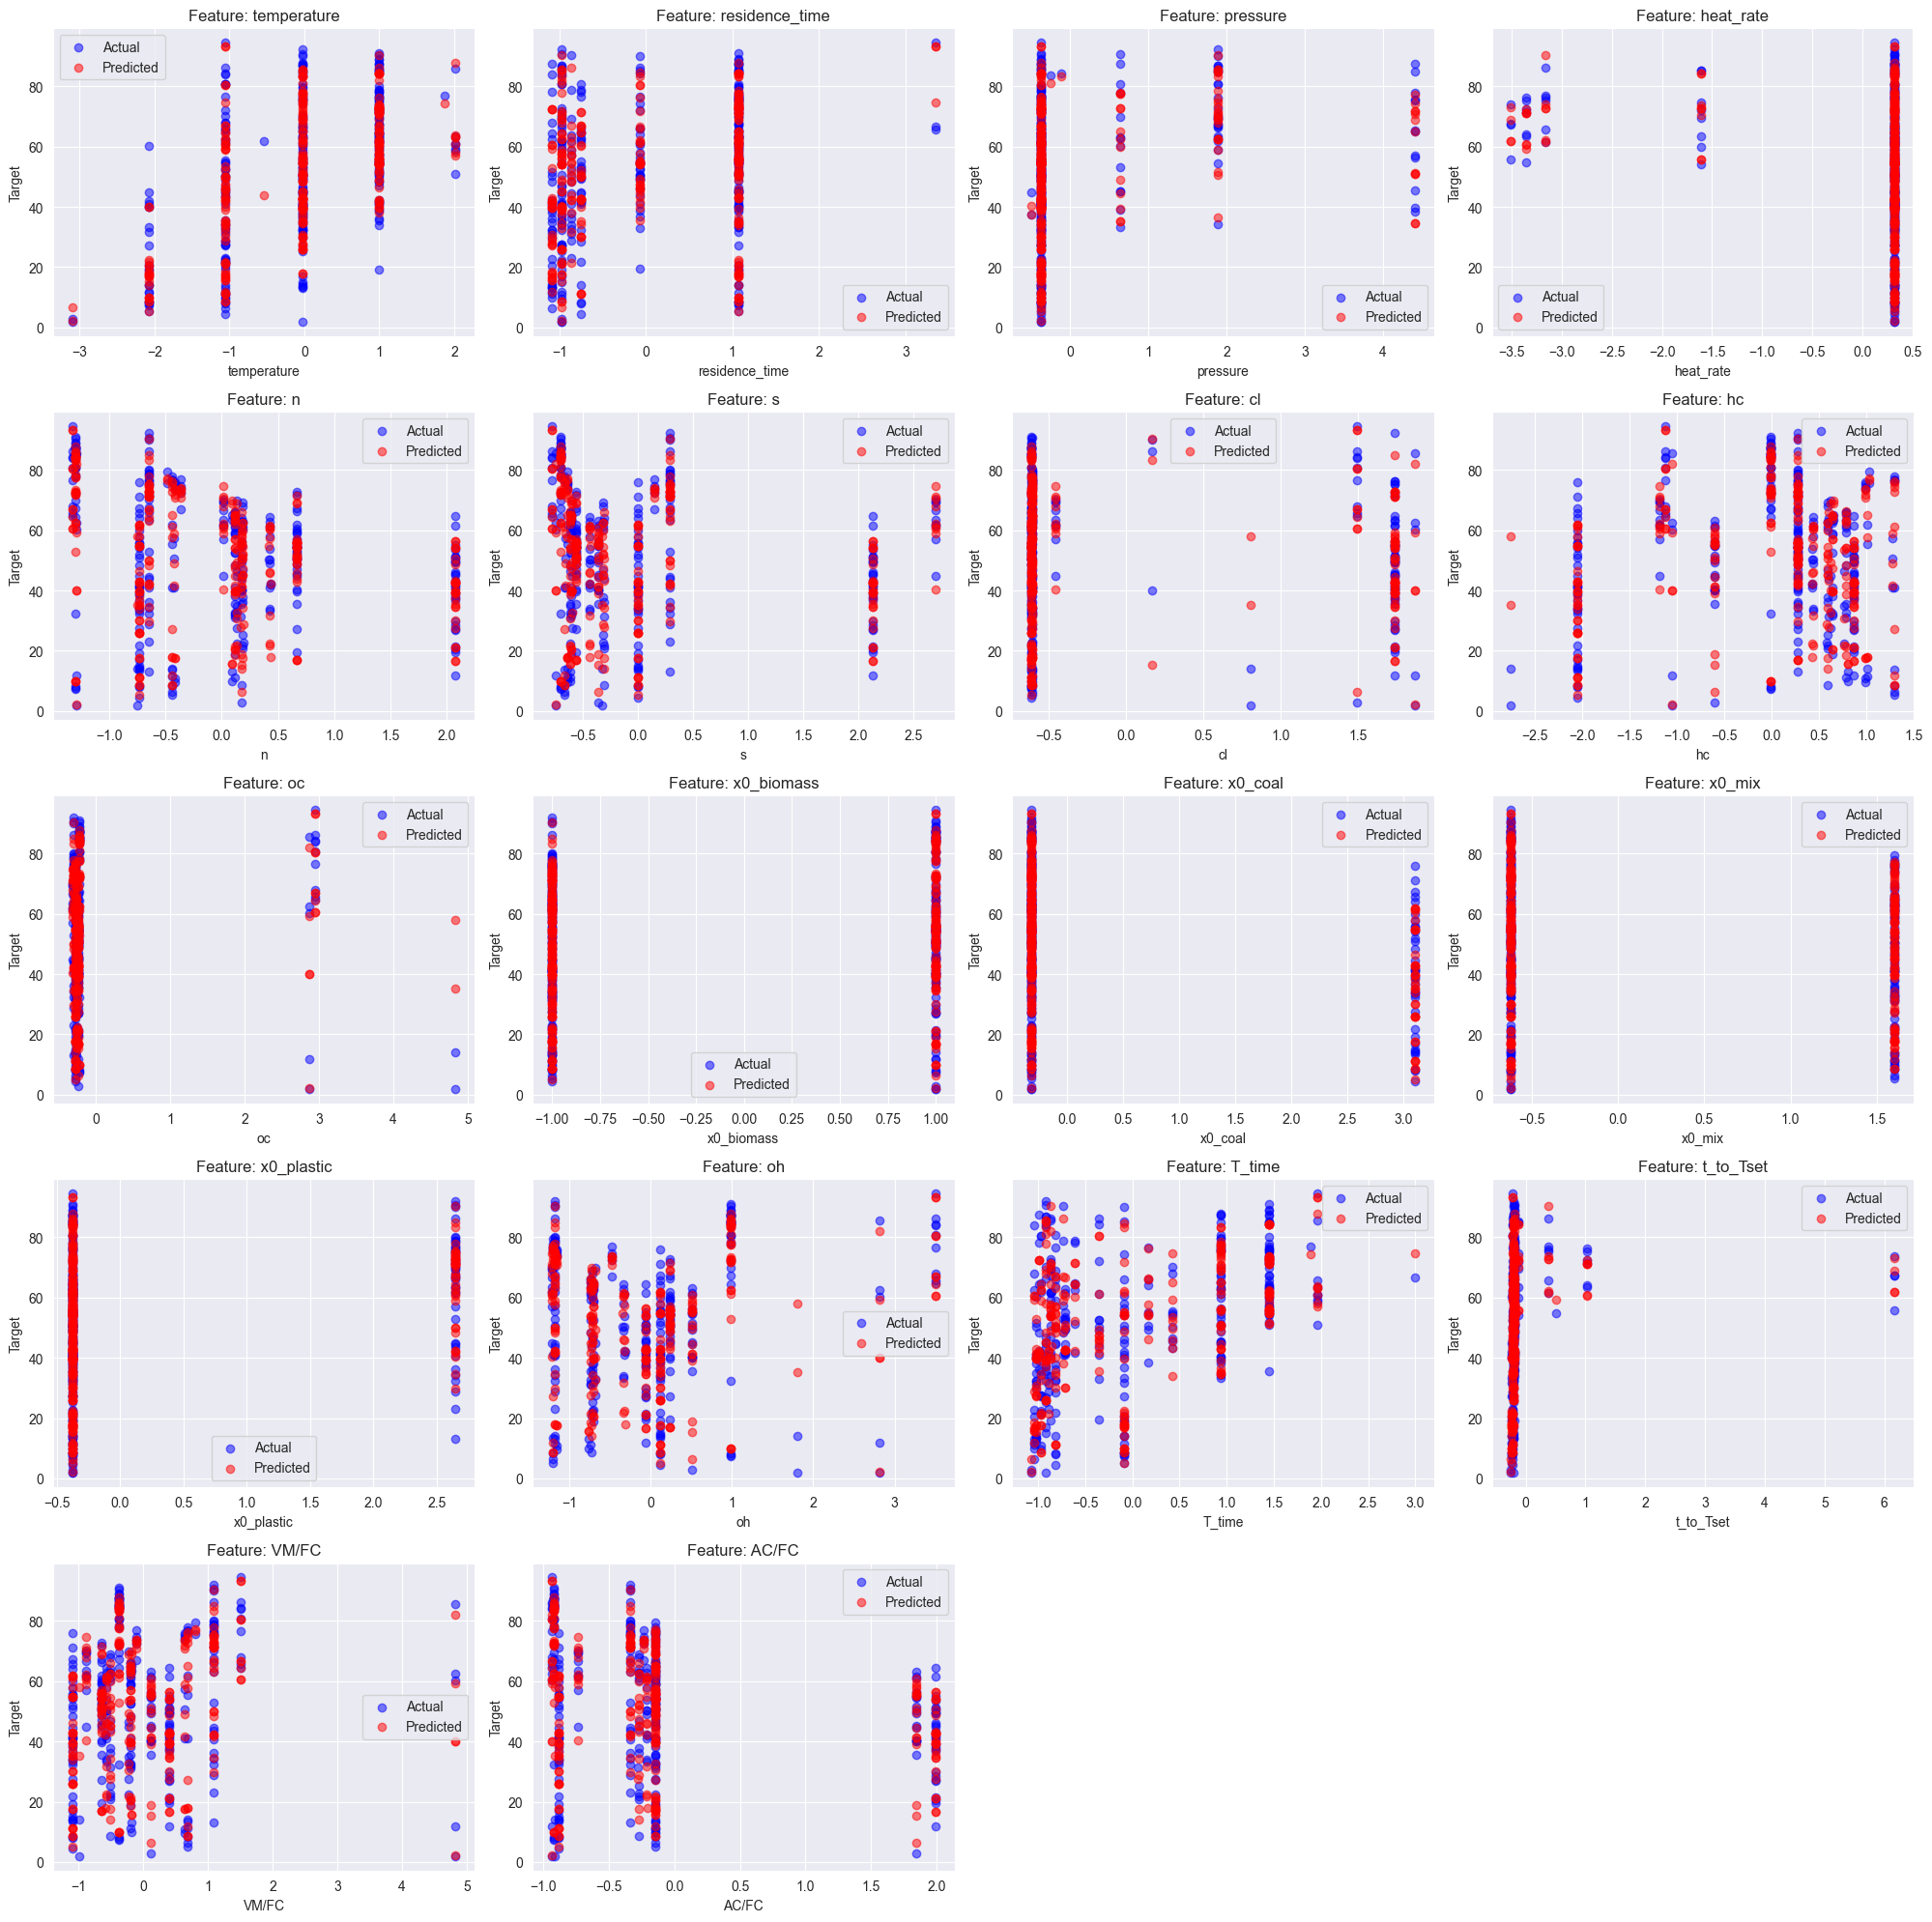

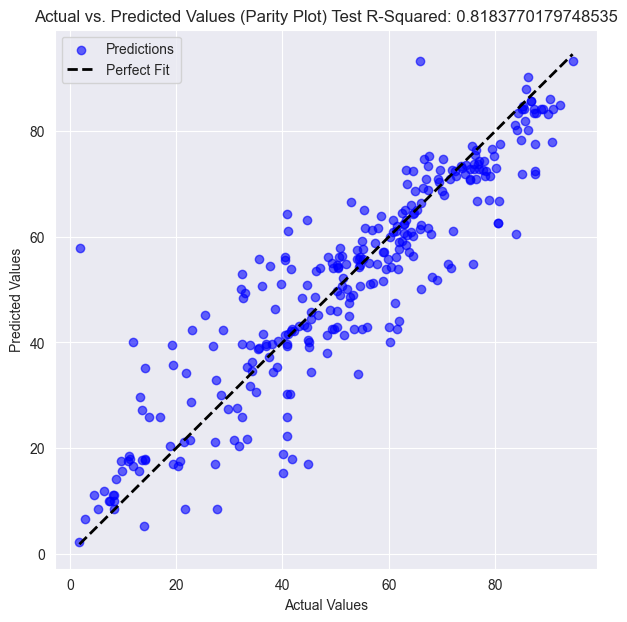

ValueError: Unable to coerce to Series, length must be 1: given 299

In [227]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
results = []


param_distributions = {
    'max_depth': [3,5, 7],
    'learning_rate': np.random.uniform(0.001, 0.2, 10),
    'subsample': np.random.uniform(0.6, 1.0, 10),
    'colsample_bytree': np.random.uniform(0.6, 1.0, 10),
    'gamma': np.random.uniform(0, 1, 10),
    'alpha': np.random.uniform(0, 1, 10),
    'min_child_weight': np.random.uniform(1, 3, 10),
}

# Number of random configurations and boosting rounds to test
n_iter = 50
boost_rounds = [100, 200, 300]

# Initialize placeholders for results
best_params = None
best_score = float('inf')
best_num_boost_round = None

print("Starting Random Search...")
for i in range(n_iter):
    # Randomly sample parameters
    params = {
        'max_depth': np.random.choice(param_distributions['max_depth']),
        'learning_rate': np.random.choice(param_distributions['learning_rate']),
        'subsample': np.random.choice(param_distributions['subsample']),
        'colsample_bytree': np.random.choice(param_distributions['colsample_bytree']),
        'gamma': np.random.choice(param_distributions['gamma']),
        'alpha': np.random.choice(param_distributions['alpha']),
        'min_child_weight': np.random.choice(param_distributions['min_child_weight']),
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
    }

    for num_boost_round in boost_rounds:
        print(f"Testing params: {params} with num_boost_round={num_boost_round}")
        fold_scores = []

        # Cross-validate using only the training set
        for train_index, val_index in kf.split(X_train, y_train):
            X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
            y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

            model = XGBRegressor(
                max_depth=params['max_depth'],
                learning_rate=params['learning_rate'],
                subsample=params['subsample'],
                objective='reg:squarederror',
                colsample_bytree=params['colsample_bytree'],
                gamma=params['gamma'],
                alpha=params['alpha'],
                min_child_weight=params['min_child_weight'],
                n_estimators=num_boost_round,
                eval_metric='rmse',  # Evaluation metric for validation
                random_state=42
            )

            model.fit(X_train_fold, y_train_fold, eval_set=[(X_val_fold, y_val_fold)], verbose=False)

            # Prediction and evaluation
            y_pred = model.predict(X_val_fold)
            rmse = mean_squared_error(y_val_fold, y_pred)
            fold_scores.append(rmse)

        # Calculate mean RMSE for the combination
        mean_rmse = np.mean(fold_scores)
        print(f"Mean RMSE: {mean_rmse} for params {params} and num_boost_round={num_boost_round}")

        # Save the best parameters and boosting rounds
        results.append((mean_rmse, params, num_boost_round))
        if mean_rmse < best_score:
            best_score = mean_rmse
            best_params = params
            best_num_boost_round = num_boost_round

# Train the final model on the entire training set with the best parameters
print("\nTraining final model with best parameters...")
final_model = XGBRegressor(
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    gamma=best_params['gamma'],
    alpha=best_params['alpha'],
    min_child_weight=best_params['min_child_weight'],
    objective='reg:squarederror',
    n_estimators=best_num_boost_round,
    eval_metric='rmse',
    random_state=42
)

final_model.fit(X_train, y_train)

# Evaluate on the test set
y_pred_test = final_model.predict(X_test)
test_rmse = mean_squared_error(y_test, y_pred_test)
test_r2 = r2_score(y_test, y_pred_test)


importances = final_model.feature_importances_
feature_names = X_train.columns

# Sort feature importance
sorted_idx = importances.argsort()[::-1]
sorted_features = [feature_names[i] for i in sorted_idx]

# Plot
plt.figure(figsize=(10, 6))
plt.barh(sorted_features, importances[sorted_idx], color='royalblue')
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importance in XGBoost Model")
plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.show()

explainer = shap.Explainer(final_model)
shap_values = explainer(X_train)

# Visualize the SHAP summary plot
shap.summary_plot(shap_values, X_train, feature_names=feature_names)

print(f"\nBest parameters (grid search): {best_params}")
print(f"\nTest Set Performance:")
print(f"Test RMSE: {test_rmse}")
print(f"Test R-Squared: {test_r2}")


# Determine the number of features
num_features = X_test.shape[1]

# Define the grid dimensions for subplots (e.g., 3 rows x 4 columns for 12 features)
n_cols = 4
n_rows = int(np.ceil(num_features / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
axes = axes.flatten()

# Loop over each feature and plot actual vs. predicted values
for i, feature in enumerate(X_test.columns):
    ax = axes[i]
    ax.scatter(X_test[feature], y_test, color='blue', alpha=0.5, label='Actual')
    ax.scatter(X_test[feature], y_pred_test, color='red', alpha=0.5, label='Predicted')
    ax.set_xlabel(feature)
    ax.set_ylabel('Target')
    ax.legend()
    ax.set_title(f"Feature: {feature}")

# Hide any unused subplots if the grid is larger than the number of features
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 7))
plt.scatter(y_test, y_pred_test, color='blue', alpha=0.6, label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Perfect Fit')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values (Parity Plot) ' + f"Test R-Squared: {test_r2}")
plt.legend()
plt.grid(True)
plt.show()

y_pred_test = y_pred_test.flatten()

residuals = y_test - y_pred_test

plt.figure(figsize=(7, 5))
plt.scatter(y_pred_test, residuals, color='red', alpha=0.6)
plt.axhline(y=0, color='black', linestyle='--', lw=2)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residual Plot')
plt.grid(True)
plt.show()

plt.figure(figsize=(7, 5))
plt.scatter(X_test['hc'], y_pred_test, color='red', alpha=0.6)
plt.scatter(X_test['hc'], y_test, color='blue', alpha=0.6)
plt.axhline(y=0, color='black', linestyle='--', lw=2)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residual Plot')
plt.grid(True)
plt.show()

In [228]:
joblib.dump(final_model, r'C:\Users\demir\OneDrive\Desktop\MSc Thesis\Data\separate_samples\lightgbm_encoded_shuffled_zscore2.pkl')

['C:\\Users\\demir\\OneDrive\\Desktop\\MSc Thesis\\Data\\separate_samples\\lightgbm_encoded_shuffled_zscore2.pkl']

In [231]:
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt
import shap
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

kf = KFold(n_splits=5, shuffle=True, random_state=42)
results = []

param_distributions = {
    'num_layers': [2, 3, 4],
    'neurons_per_layer': [32, 64, 128],
    'learning_rate': np.random.uniform(0.001, 0.1, 10),
    'batch_size': [16, 32, 64],
    'epochs': [50, 100, 150]
}

n_iter = 50
best_params = None
best_score = float('inf')

def build_ann(num_layers, neurons_per_layer, learning_rate):
    model = keras.Sequential()
    model.add(layers.Input(shape=(X_train.shape[1],)))
    for _ in range(num_layers):
        model.add(layers.Dense(neurons_per_layer, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss='mse')
    return model

print("Starting Random Search...")
for i in range(n_iter):
    params = {
        'num_layers': np.random.choice(param_distributions['num_layers']),
        'neurons_per_layer': np.random.choice(param_distributions['neurons_per_layer']),
        'learning_rate': np.random.choice(param_distributions['learning_rate']),
        'batch_size': np.random.choice(param_distributions['batch_size']),
        'epochs': np.random.choice(param_distributions['epochs'])
    }

    fold_scores = []
    for train_index, val_index in kf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

        model = build_ann(params['num_layers'], params['neurons_per_layer'], params['learning_rate'])
        model.fit(X_train_fold, y_train_fold, epochs=params['epochs'], batch_size=params['batch_size'], verbose=0, validation_data=(X_val_fold, y_val_fold))

        y_pred = model.predict(X_val_fold)
        rmse = mean_squared_error(y_val_fold, y_pred, squared=False)
        fold_scores.append(rmse)

    mean_rmse = np.mean(fold_scores)
    results.append((mean_rmse, params))
    if mean_rmse < best_score:
        best_score = mean_rmse
        best_params = params

print("\nTraining final model with best parameters...")
final_model = build_ann(best_params['num_layers'], best_params['neurons_per_layer'], best_params['learning_rate'])
final_model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0)

y_pred_test = final_model.predict(X_test)
test_rmse = mean_squared_error(y_test, y_pred_test, squared=False)
test_r2 = r2_score(y_test, y_pred_test)

print(f"\nBest parameters: {best_params}")
print(f"Test RMSE: {test_rmse}")
print(f"Test R-Squared: {test_r2}")

plt.figure(figsize=(7, 7))
plt.scatter(y_test, y_pred_test, color='blue', alpha=0.6, label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Perfect Fit')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values (Parity Plot) ' + f"Test R-Squared: {test_r2}")
plt.legend()
plt.grid(True)
plt.show()

y_pred_test = y_pred_test.flatten()
residuals = y_test - y_pred_test

plt.figure(figsize=(7, 5))
plt.scatter(y_pred_test, residuals, color='red', alpha=0.6)
plt.axhline(y=0, color='black', linestyle='--', lw=2)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residual Plot')
plt.grid(True)
plt.show()

TypeError: unhashable type: 'list'

In [35]:
data.describe()

,temperature,residence_time,pressure,heat_rate,wc,vm,fc,ac,c,h,o,n,s,cl,hc,oc,lhv,devol_yield
count,1990.000000,1990.000000,1990.000000,1990.000000,1990.000000,1990.000000,1990.000000,1990.000000,1990.000000,1990.000000,1990.000000,1990.000000,1990.000000,1450.000000,1990.000000,1990.000000,1784.000000,1990.000000
mean,804.517588,5.311809,2.479899,919.899497,6.619043,62.191479,14.853130,16.346482,49.607812,5.960018,20.004316,1.672393,0.594517,0.367320,1.404062,1.562463,21.094298,52.140244
std,195.916696,4.401299,4.043454,254.790187,2.683913,13.268101,10.438169,12.537470,13.089359,1.917607,10.652722,1.056971,0.698262,0.626146,0.342027,4.913049,6.760016,22.261759
min,200.000000,0.500000,0.500000,10.000000,2.600000,44.200000,3.064326,0.000000,32.400000,3.265000,7.000000,0.269662,0.046420,0.000000,0.461416,0.000000,13.528000,-20.537715
25%,600.000000,1.000000,1.000000,1000.000000,4.896000,50.700000,7.000000,4.200000,37.500000,4.600000,15.133141,0.900000,0.163860,0.000000,1.200000,0.200000,15.055000,37.520729
50%,800.000000,5.000000,1.000000,1000.000000,7.345000,58.900000,11.704000,17.538000,50.388388,5.700000,16.600000,1.783280,0.291614,0.001000,1.500000,0.327028,19.843000,54.327834
75%,1000.000000,10.000000,1.000000,1000.000000,7.896696,75.400000,16.400000,23.700000,61.224000,7.196250,21.200000,2.142543,0.600000,0.906227,1.668000,0.400000,27.129260,67.793025
max,1200.000000,20.000000,20.000000,1000.000000,10.800000,91.735674,40.900000,37.520000,82.300000,10.132050,54.936839,3.900000,2.500000,1.585535,1.857000,26.102250,35.800000,99.756944


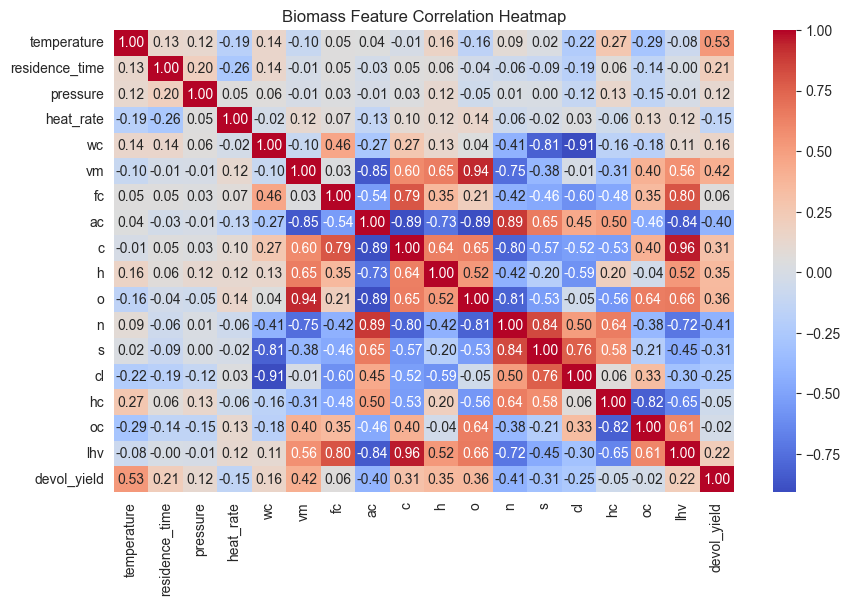

      sample  temperature  residence_time  pressure  heat_rate   wc    vm  \
0  sewage_82          600             0.5       1.0       1000  3.2  53.7   
1  sewage_83          600             0.5       1.0       1000  3.2  53.7   
2  sewage_84          600             0.5       1.0       1000  3.2  53.7   
3  sewage_85          600             1.0       1.0       1000  3.2  53.7   
4  sewage_86          600             1.0       1.0       1000  3.2  53.7   

     fc     ac     c    h      o    n    s   cl        hc        oc     lhv  \
0  6.41  36.69  32.4  4.6  17.11  3.9  2.1  1.5  1.703704  0.396065  13.943   
1  6.41  36.69  32.4  4.6  17.11  3.9  2.1  1.5  1.703704  0.396065  13.943   
2  6.41  36.69  32.4  4.6  17.11  3.9  2.1  1.5  1.703704  0.396065  13.943   
3  6.41  36.69  32.4  4.6  17.11  3.9  2.1  1.5  1.703704  0.396065  13.943   
4  6.41  36.69  32.4  4.6  17.11  3.9  2.1  1.5  1.703704  0.396065  13.943   

   devol_yield Category  
0     9.630702  biomass  
1    20.48

In [34]:
biomass_data = pd.read_csv(r"C:\Users\demir\OneDrive\Desktop\MSc Thesis\Data\separate_samples\biomass.csv")
bio_corr = biomass_data.drop(['sample','Category'], axis=1).corr()
plt.figure(figsize=(10, 6))
sns.heatmap(bio_corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Biomass Feature Correlation Heatmap")
plt.show()

print(biomass_data.head())

In [48]:
coal_data = pd.read_csv(r"C:\Users\demir\OneDrive\Desktop\MSc Thesis\Data\separate_samples\coal.csv")
plastic_data = pd.read_csv(r"C:\Users\demir\OneDrive\Desktop\MSc Thesis\Data\separate_samples\plastic.csv")
mix_data = pd.read_csv(r"C:\Users\demir\OneDrive\Desktop\MSc Thesis\Data\separate_samples\mix.csv")

In [47]:
coal_data.head()

,sample,temperature,residence_time,pressure,heat_rate,wc,vm,fc,ac,c,h,o,n,s,cl,hc,oc,lhv,devol_yield,Category
0,brown_coal_1,600,0.5,1.0,1000,10.8,44.2,40.9,4.2,63.4,3.9,16.2,0.9,0.6,0.0,0.7,0.2,20.13,3.437227,coal
1,brown_coal_2,600,0.5,1.0,1000,10.8,44.2,40.9,4.2,63.4,3.9,16.2,0.9,0.6,0.0,0.7,0.2,20.13,3.163017,coal
2,brown_coal_3,600,0.5,1.0,1000,10.8,44.2,40.9,4.2,63.4,3.9,16.2,0.9,0.6,0.0,0.7,0.2,20.13,4.827940,coal
3,brown_coal_4,600,0.5,1.0,1000,10.8,44.2,40.9,4.2,63.4,3.9,16.2,0.9,0.6,0.0,0.7,0.2,20.13,4.509894,coal
4,brown_coal_5,600,1.0,1.0,1000,10.8,44.2,40.9,4.2,63.4,3.9,16.2,0.9,0.6,0.0,0.7,0.2,20.13,4.128819,coal


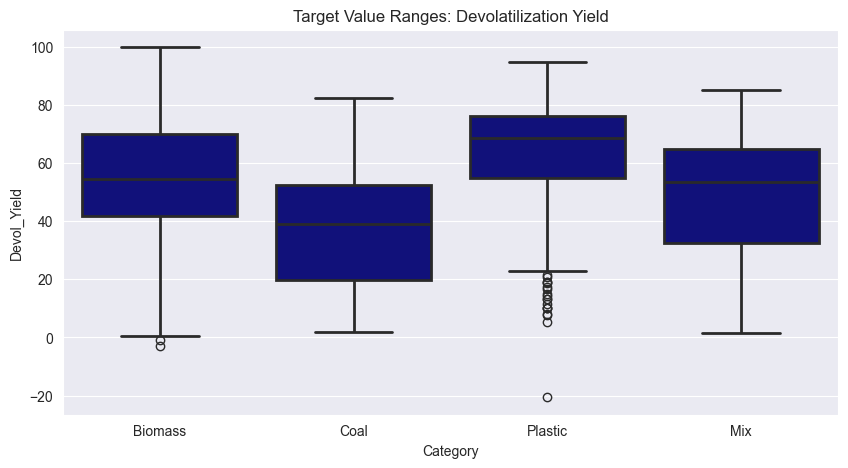

In [58]:
df_combined = pd.concat([biomass_data, coal_data, mix_data, plastic_data], axis=0)

# Plot with category on x-axis and numerical values on y-axis
plt.figure(figsize=(10, 5))
sns.boxplot(x='Category', y='Devol_Yield', data=df_combined, color='darkblue', linewidth=2)
plt.title("Target Value Ranges: Devolatilization Yield")
plt.show()

In [187]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle
overall = pd.concat([biomass_data, coal_data, mix_data, plastic_data], axis=0)

# 'Category' sütununu 2D hale getir
category_reshaped = overall[['Category']].values  # 2D array formatında al

# One-hot encoding uygula
encoder = OneHotEncoder(sparse_output=False)
one_hot_encoded = encoder.fit_transform(category_reshaped)

# Yeni sütun isimlerini al
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(), index=overall.index)

# DataFrame'leri birleştirmeden önce indeksleri sıfırla
overall = overall.reset_index(drop=True)
one_hot_df = one_hot_df.reset_index(drop=True)

# Orijinal veriye ekleyip, eski 'Category' sütununu çıkar
overall_encoded = pd.concat([overall, one_hot_df], axis=1).drop(columns=['Category'])

# Shuffle the dataset
shuffled_data = shuffle(overall_encoded, random_state=42)

# Display the first few rows of the shuffled data
print(shuffled_data.head())


shuffled_data.to_csv(r"C:\Users\demir\OneDrive\Desktop\MSc Thesis\Data\separate_samples\encoded_shuffled.csv", index=False)



              sample  temperature  residence_time  pressure  heat_rate  \
887            dgt_1          400             1.0      10.0       1000   
1670    dgst_car_126          600             2.0       1.0       1000   
414          wood_66         1000            10.0       5.0       1000   
1080  brown_coal_246         1000             1.0       1.0       1000   
1102        bcoal_18         1000            10.0       1.0        500   

             wc         vm         fc         ac          c  ...         s  \
887   10.200000  50.700000  15.400000  23.700000  37.500000  ...  0.200000   
1670   7.949117  55.157095  15.238691  21.655097  43.939155  ...  0.288666   
414    7.600000  75.400000  16.400000   0.600000  50.400000  ...  0.100000   
1080  10.800000  44.200000  40.900000   4.200000  63.400000  ...  0.600000   
1102  10.800000  44.200000  40.900000   4.200000  63.400000  ...  0.600000   

       cl        hc        oc     lhv  devol_yield  x0_biomass  x0_coal  \
887   0.0  